# Úkol č. 1 - vizualizace dat a web scraping (do 11. října)

  * V rámci tohoto úkolu musíte stáhnout dat z webu (tzv. _web scraping_, velmi základní) a následně data zpracovat a vizualizovat.
  * Cílem bude stáhnout data ze serveru https://www.psp.cz/sqw/hlasovani.sqw?o=8 týkající hlasování současné poslanecké sněmovny, uložit tato data v tabulkovém formátu a pak vymyslet vizualizace a zobrazení dat, které umožní orientaci v těchto datech a zvýrazní zajímavé informace a zobrazit přehledně časový vývoj různých veličin.
 
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

## Data

 * Měli byste stáhnout data ze všech hlasování současné poslanecké sněmovny (tj. od voleb v roce 2017) a to až na úroveň jednotlivých poslanců. 
 * Data by měla obsahovat i stručný popis toho, o jaké hlasování šlo.

## Pokyny k vypracování

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
  * Strojově stáhněte data a uložte je do vhodného formátu, který se Vám bude dále dobře zpracovávat. 
  * **I když nemusíte mít sněmovnu rádi, snažte se nezahltit server a mezi požadavky na stránku mějte alespoň vteřinu mezeru.**
  * V druhé části Vašeho Jupyter notebooku pracujte se staženými daty v souborech, které jsou výsledkem Vašeho stahovacího skriptu (aby opravující nemusel spouštět stahování z webu).
  * S využitím vybraných nástrojů zpracujte data a vymyslete vizualizace a grafy, aby bylo vidět následující:
    * Odchody a přeběhnutí poslanců mezi jednotlivými stranami.
    * Jakou mají jednotliví poslanci docházku (účast na hlasování) a jak jsou na tom s docházkou strany jako celek.
    * Jak často spolu jednotlivé strany hlasují ve shodě a jak často hlasují odlišně.
    * Jak jsou poslanci jednotlivých stran jednotní v hlasování (jak často hlasují stejně, kdo jsou největší rebelové).

**Další body zadání** za případné další body (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
  * Ve vizualizacích a grafech nějak zachyťte časový vývoj (např. jak se mění docházka, shoda mezi stranami atp.).
  * Najděte jednotlivé poslance, kteří se nejvíce shodují při svém hlasování či kteří mají co nejpodobnější účast na hlasování.
  * Zkuste rozlišit v datech důležitá hlasování a zpracujte vizualizace (také) pro ně.
  * Zkuste najít hlasování, kde poslanci hlasovali nejvíce jinak, než obvykle.
  
## Tipy a triky
  * Balíčky iportujte na začátku notebooku (příp. na začátku scrapovací a pak na začátku vizualizační části).
  * Využívejte markdown buňky (jako je ta, ve které je tento text) a naspisy, abyste usnadnily orientaci opravující(mu).
  * Pečlivě si vybírejte grafy a vizualizace, aby co nejlépe vyjádřily to, co vyjádřit chcete. Doporučuji projít si pro inspiraci alespoň galerie balíčků `matplotlib` a `seaborn`.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte Jupyter Notebook (příp. doplněn skripty), ale i soubor(y) se staženými daty (ať opravující nemusí stahovat data).
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni.

# PSP Visualization
## I.part - Data Mining
* First approach to get the data is to download whole set from original page(because it is government - is should release the data) but unfortunately the data are (for me) in really bad structure and the point of this task was to try at least basic scraping tools.
* So, let's try another approach but at first we should get to know the data (I do personally see the data for second time or so..). The page with voting results itself has in url argument `g`, which seems to increment in next voting results pages. 
* So I created iteration from first voting id (`g` in url) to the last url, then on each page I will iterate over parties with help of BeautifulSoup(plus extract the title and session number from the heading). Firstly I tried to limit downloading by 1 second pause between requests but that was really slow so I made the pause half the second - it is still really slow but I leave that be.
* After several tries to scrape the data I realized that I need to save some partial results.So every session I scrape - I'll save into csv. In the meantime I can start to prepare the visualisation part and if the scraping part failed or other errors (e.g. pc shutdown) occured I could start downloading from the current position (which can save a lot of time and energy)
* But the speed of downloading was quite slow so I started inspecting why is that.I've developed this task on really old laptop so I did not suspect anything in the beginning but then I take `time` tool and make measurements.The outcome was that one page took 30 seconds so investigated further.And it turns up that appending into DataFrame is really slow - about 0,15 s which is not that bad but If I do it on every mp so every voting page  times 200 that would take 2 days to scrape about 7000 pages :D. I changed structure of data from `DataFrame` to regular array of dictionaries and after whole downloading I create `DataFrame` from scraped data.
* During downloading I've noticed some irregularities in data so I had to check data if the number of voting results corresponds to the correct number.

In [1]:
# import all the neccessary libs
import requests
import time
from bs4 import BeautifulSoup
import pandas as pd

tmp = []

# vote_id
max_vote_id = 73901
min_vote_id = 67018

# iterate over all the votes within the range
for vote_id in range(min_vote_id, max_vote_id + 1):
    try: 
        # await for a while to prevent blocking from the provider
        time.sleep(0.5)
        start = time.time()
        
        # make http get request
        url= 'https://www.psp.cz/sqw/hlasy.sqw?g=' + str(vote_id)
        r = requests.get(url)
        
        # parse the document into the soup :)
        soup = BeautifulSoup(r.text, 'html.parser')

        # hack to extract title of voting procedure
        vote_title = ''.join(soup.find('h1').find('br').next_siblings)
        vote_description = soup.find('h1').next_element.strip().split(',')[0]

        # focus on the main part of the page (to prevent finding incorrect elements)
        soup_main = soup.find('div',{"id": "main-content"})

        # iterate over all the parties (+ remove first and last title - clear the data)
        for party in soup_main.find_all('h2',{"class": "section-title"})[1:-1]:
            # extract the name of the party
            party_name = party.span.find(text=True, recursive=False).split(sep=' ')[0]
            
            # iterate over all the member of parlaments of the current party
            for mp in party.findNext('ul'):
                # extract name and vote
           
                mp_name = mp.get_text().split(' ')[1].split('(')[0]
                mp_vote = mp.get_text().split(' ')[0]
                
                # create row object and then insert into dataframe
                row = {'Vote description': vote_description,'Vote Id': vote_id, 'Vote Title': vote_title, 'Party': party_name, 'MP': mp_name,'Vote': mp_vote}
                tmp.append(row) 
            
        # print the result and time of execution    
        end = time.time()    
        print(vote_description + ' ' + vote_title + ' ' + str(vote_id) + ' time: ' + str(end - start))
    except Exception as e: 
        print("exception", end=' ')
        print(e)

df = pd.DataFrame(tmp, columns=['Vote description', 'Vote Id', 'Vote Title', 'Party', 'MP', 'Vote'])

# export data
export_file = 'export.csv'
df.to_csv(export_file, index=False) 

print("export is done to " + export_file)

1. schůze Inf. o ustavení volební komise PS a volbě členů 67018 time: 0.5793607234954834
1. schůze Inf. o ustavení volební komise PS a volbě členů 67019 time: 0.5864279270172119
1. schůze  67020 time: 0.43860340118408203
1. schůze Náv.na stanovení počtu čl. MIV 67021 time: 1.4595437049865723
1. schůze Náv.na stanovení počtu čl. MIV 67022 time: 0.5012352466583252
1. schůze Návrh na ustavení MIV 67023 time: 0.4432692527770996
1. schůze Návrh na potvrzení předsedy MIV 67024 time: 0.4069023132324219
1. schůze Inf. MIV o ověření platnosti volby poslanců 67025 time: 0.41542935371398926
1. schůze Návrh na stanovení počtu místopředsedů PS 67026 time: 0.42141222953796387
1. schůze Návrh na stanovení počtu místopředsedů PS 67027 time: 0.4406890869140625
1. schůze Návrh na stanovení počtu ověřovatelů PS 67028 time: 1.2398991584777832
1. schůze Návrh na nominaci ověřovatelů PS 67029 time: 0.38187599182128906
1. schůze Návrh na nominaci ověřovatelů PS 67030 time: 0.46460914611816406
1. schůze Návrh

4. schůze Návrh na volbu členů nebo ustavení SK GIBS 67127 time: 5.469752311706543
4. schůze Návrh na volbu členů nebo ustavení SK KPO 67128 time: 0.4221630096435547
4. schůze Návrh na volbu členů nebo ustavení SK CEÚ 67129 time: 0.44046616554260254
4. schůze Návrh na volbu členů nebo ustavení SK BIS 67130 time: 0.4797186851501465
4. schůze Návrh na volbu členů nebo ustavení SK NBÚ 67131 time: 0.431563138961792
4. schůze Návrh na volbu členů nebo ustavení SK VZ 67132 time: 0.3856313228607178
4. schůze Návrh na volbu členů nebo ustavení SK FAÚ 67133 time: 0.4047684669494629
4. schůze Návrh na volbu členů nebo ustavení SK NÚKIB 67134 time: 0.3922457695007324
4. schůze Návrh na volbu členů do stálých delegací Parlamentu 67135 time: 0.4166412353515625
4. schůze Návrh na volbu členů do stálých delegací Parlamentu 67136 time: 3.5906598567962646
4. schůze Návrh na volbu členů do stálých delegací Parlamentu 67137 time: 0.465177059173584
4. schůze Návrh na volbu členů do stálých delegací Parlam

4. schůze Vl.n.z. o státním rozpočtu ČR na rok 2018 67224 time: 0.5666186809539795
4. schůze Vl.n.z. o státním rozpočtu ČR na rok 2018 67225 time: 0.49633026123046875
4. schůze Vl.n.z. o státním rozpočtu ČR na rok 2018 67226 time: 0.4532473087310791
4. schůze Vl.n.z. o státním rozpočtu ČR na rok 2018 67227 time: 0.5026359558105469
4. schůze Vl.n.z. o státním rozpočtu ČR na rok 2018 67228 time: 0.46769070625305176
4. schůze Vl.n.z. o státním rozpočtu ČR na rok 2018 67229 time: 0.41835641860961914
4. schůze Vl.n.z. o státním rozpočtu ČR na rok 2018 67230 time: 1.5423083305358887
4. schůze Vl.n.z. o státním rozpočtu ČR na rok 2018 67231 time: 0.48462557792663574
4. schůze Vl.n.z. o státním rozpočtu ČR na rok 2018 67232 time: 0.9550197124481201
4. schůze Vl.n.z. o státním rozpočtu ČR na rok 2018 67233 time: 0.3842160701751709
4. schůze Vl.n.z. o státním rozpočtu ČR na rok 2018 67234 time: 0.44773268699645996
4. schůze Vl.n.z. o státním rozpočtu ČR na rok 2018 67235 time: 0.4573380947113037

6. schůze Pořad schůze 67332 time: 1.4422941207885742
6. schůze Sml. mezi ČR a Vietnamem o spolupráci proti tr. činnosti 67333 time: 0.39516544342041016
6. schůze Dodatkový protokol k Trestněprávní úmluvě o korupci 67334 time: 0.474759578704834
6. schůze Dohoda mezi ČR a Japonskem o vízech k prac. dovolené 67335 time: 1.508678674697876
6. schůze Novela z. - daňový řád - EU 67336 time: 0.49941396713256836
6. schůze Novela z. - daňový řád - EU 67337 time: 0.460085391998291
6. schůze Novela z. - daňový řád - EU 67338 time: 1.468174934387207
6. schůze Vl.n.z. o distribuci pojištění a zajištění - EU 67339 time: 0.438704252243042
6. schůze Vl.n.z. v souv. s přij. zák. o distrib. pojiš. a zajiš. 67340 time: 0.4445841312408447
6. schůze Vl.n.z. v souv. s přij. zák. o distrib. pojiš. a zajiš. 67341 time: 0.48176121711730957
6. schůze Vl.n.z. v souv. s přij. zák. o distrib. pojiš. a zajiš. 67342 time: 0.45027875900268555
6. schůze Vl.n.z. v souv. s přij. zák. o distrib. pojiš. a zajiš. 67343 tim

7. schůze Novela z. o mezinárodní justiční spolupráci ve věcech trest. - EU 67448 time: 0.5303428173065186
7. schůze Novela z. o mezinárodní justiční spolupráci ve věcech trest. - EU 67449 time: 0.47867894172668457
7. schůze Vl.n.z.o poskyt.st.záruky ČR na zajištění půjčky ČNB pro MMF 67450 time: 0.8345978260040283
7. schůze N. z. o činnosti inst. zaměstnaneckého penzijního pojištění - EU 67451 time: 0.46236491203308105
7. schůze Novela z. o vývozu a dovozu zboží - EU 67452 time: 0.5137674808502197
7. schůze Novela z. o vývozu a dovozu zboží - EU 67453 time: 0.5003094673156738
7. schůze Novela z. o vývozu a dovozu zboží - EU 67454 time: 0.5681219100952148
7. schůze Novela z. - insolvenční zákon - EU 67455 time: 0.5226242542266846
7. schůze Novela z. - insolvenční zákon - EU 67456 time: 0.6004235744476318
7. schůze Novela z. - insolvenční zákon - EU 67457 time: 0.5314178466796875
7. schůze Novela z. - insolvenční zákon - EU 67458 time: 0.4184577465057373
7. schůze Novela z. - insolvenčn

12. schůze Novela z. o majetku České republiky 67555 time: 0.5149290561676025
12. schůze Novela z. - trestní řád 67556 time: 0.46018123626708984
12. schůze Novela z. o daních z příjmů 67557 time: 0.4742472171783447
12. schůze Písemná interpelace J. Michálka na A. Babiše ve věci neutěšených platů 67558 time: 0.5027346611022949
12. schůze Novela z. o daních z příjmů 67559 time: 0.47930312156677246
12. schůze Novela z. o daních z příjmů 67560 time: 0.5147140026092529
12. schůze Novela z. o směnárenské činnosti 67561 time: 0.5260756015777588
12. schůze Novela z. o směnárenské činnosti 67562 time: 0.5539937019348145
12. schůze Novela z. o směnárenské činnosti 67563 time: 0.5078039169311523
12. schůze Novela z. o směnárenské činnosti 67564 time: 0.5978121757507324
12. schůze Novela z. o směnárenské činnosti 67565 time: 0.5372257232666016
12. schůze Novela z. o některých přestupcích 67566 time: 5.5121519565582275
12. schůze Pořad schůze 67567 time: 0.48343443870544434
12. schůze Pořad schůze 

12. schůze  67654 time: 0.4436478614807129
12. schůze Novela z. o státní službě 67655 time: 0.46961092948913574
12. schůze Vl.n.z, kterým se mění volební zákony a soudní řád správní 67656 time: 0.4901914596557617
12. schůze Vl.n.z, kterým se mění volební zákony a soudní řád správní 67657 time: 0.49305176734924316
12. schůze Vl.n.z, kterým se mění volební zákony a soudní řád správní 67658 time: 0.561633825302124
12. schůze  67659 time: 0.5185229778289795
13. schůze  67660 time: 0.4524650573730469
13. schůze Pořad schůze 67661 time: 0.5178604125976562
13. schůze Pořad schůze 67662 time: 0.4720442295074463
13. schůze Pořad schůze 67663 time: 0.5166935920715332
13. schůze Pořad schůze 67664 time: 0.5032308101654053
13. schůze Pořad schůze 67665 time: 0.44728517532348633
13. schůze Pořad schůze 67666 time: 0.45139026641845703
13. schůze Pořad schůze 67667 time: 0.4404890537261963
13. schůze Pořad schůze 67668 time: 0.4276735782623291
13. schůze Pořad schůze 67669 time: 0.49689555168151855
1

13. schůze Návrhy Poslanecké sněmovny na propůjčení nebo udělení státních vyzname 67758 time: 0.5787985324859619
13. schůze Návrhy Poslanecké sněmovny na propůjčení nebo udělení státních vyzname 67759 time: 0.5536084175109863
13. schůze Návrhy Poslanecké sněmovny na propůjčení nebo udělení státních vyzname 67760 time: 0.5812530517578125
13. schůze Návrhy Poslanecké sněmovny na propůjčení nebo udělení státních vyzname 67761 time: 0.5762848854064941
13. schůze Návrhy Poslanecké sněmovny na propůjčení nebo udělení státních vyzname 67762 time: 0.6545507907867432
13. schůze Návrhy Poslanecké sněmovny na propůjčení nebo udělení státních vyzname 67763 time: 0.48308849334716797
13. schůze Návrhy Poslanecké sněmovny na propůjčení nebo udělení státních vyzname 67764 time: 0.5212280750274658
13. schůze Návrhy Poslanecké sněmovny na propůjčení nebo udělení státních vyzname 67765 time: 0.4918656349182129
13. schůze Návrhy Poslanecké sněmovny na propůjčení nebo udělení státních vyzname 67766 time: 1

13. schůze Sml.mezi ČR a vl.Rep.Kazachstán o spol.v boji proti tr.činn. 67857 time: 0.43955016136169434
13. schůze Sml.mezi ČR a Vietnamem o předávání odsouzených osob 67858 time: 0.5961472988128662
13. schůze Úml.Rady Evropy o komp.příst.k ochraně,bezp.při sport.akcích 67859 time: 0.4589846134185791
13. schůze Rámcová dohoda mezi EU a Austrálií 67860 time: 0.4857511520385742
13. schůze Pořad schůze 67861 time: 0.4580526351928711
13. schůze Pořad schůze 67862 time: 0.48493409156799316
13. schůze Novela z. o daních z příjmů 67863 time: 0.4834439754486084
13. schůze Novela z. o daních z příjmů 67864 time: 1.5606093406677246
13. schůze Novela z. o daních z příjmů 67865 time: 0.5049760341644287
13. schůze Novela z. o daních z příjmů 67866 time: 0.5203349590301514
13. schůze Novela z. - správní řád 67867 time: 0.5657556056976318
13. schůze Novela z. - správní řád 67868 time: 0.5786070823669434
13. schůze Novela z. - správní řád 67869 time: 0.5125093460083008
13. schůze Novela z. o evidenci 

16. schůze Novela z. o urychlení výstavby dopravní infrastruktury 67964 time: 0.4436514377593994
16. schůze Novela z. o urychlení výstavby dopravní infrastruktury 67965 time: 0.8161706924438477
16. schůze Novela z. o provozu na pozemních komunikacích - EU 67966 time: 1.499516487121582
16. schůze Novela z. o provozu na pozemních komunikacích - EU 67967 time: 0.5001316070556641
16. schůze Novela z. o provozu na pozemních komunikacích - EU 67968 time: 0.4628481864929199
16. schůze Novela z. o provozu na pozemních komunikacích - EU 67969 time: 0.47609734535217285
16. schůze Novela z. o provozu na pozemních komunikacích - EU 67970 time: 0.7620508670806885
16. schůze Novela z. o provozu na pozemních komunikacích - EU 67971 time: 0.49483466148376465
16. schůze Novela z. o provozu na pozemních komunikacích - EU 67972 time: 0.5392687320709229
16. schůze Novela z. o provozu na pozemních komunikacích - EU 67973 time: 0.4733092784881592
16. schůze Novela z. o provozu na pozemních komunikacích - EU

19. schůze Novela z. o provozu na pozemních komunikacích 68075 time: 0.5233631134033203
19. schůze Novela z. o spotřebních daních 68076 time: 0.5288035869598389
19. schůze Novela z. o spotřebních daních 68077 time: 0.5809950828552246
19. schůze Novela z. o spotřebních daních 68078 time: 1.468397617340088
19. schůze Novela z. o spotřebních daních 68079 time: 0.5503134727478027
19. schůze Novela z. o spotřebních daních 68080 time: 0.667731761932373
19. schůze Novela z. o státních svátcích 68081 time: 0.6257340908050537
19. schůze Novela z. o státních svátcích 68082 time: 0.4802055358886719
19. schůze Novela z. o prodejní době 68083 time: 0.5005433559417725
19. schůze Novela z. o prodejní době 68084 time: 0.43770599365234375
19. schůze Novela z. o prodejní době 68085 time: 0.4977383613586426
19. schůze Vl.n.z. v souvislosti s nařízením EP a Rady o rtuti - EU 68086 time: 1.5731806755065918
19. schůze Vl.n.z. v souvislosti s nařízením EP a Rady o rtuti - EU 68087 time: 0.5132215023040771
19

19. schůze Novela z. o poskytování dávek osobám se zdravot. postižením 68183 time: 0.48000597953796387
19. schůze Novela z. o poskytování dávek osobám se zdravot. postižením 68184 time: 0.5132217407226562
19. schůze Novela z. o poskytování dávek osobám se zdravot. postižením 68185 time: 0.4304955005645752
19. schůze Novela z. o poskytování dávek osobám se zdravot. postižením 68186 time: 0.4621424674987793
19. schůze Novela z. o poskytování dávek osobám se zdravot. postižením 68187 time: 0.4706919193267822
19. schůze Novela z. o poskytování dávek osobám se zdravot. postižením 68188 time: 0.5368075370788574
19. schůze Novela z. o pobytu cizinců na území ČR - EU 68189 time: 0.5220789909362793
19. schůze Novela z. o pobytu cizinců na území ČR - EU 68190 time: 0.5059356689453125
19. schůze Novela z. o pobytu cizinců na území ČR - EU 68191 time: 0.6063144207000732
19. schůze Informace vlády o postoji ČR ke glob. paktu o migraci 68192 time: 0.8382742404937744
19. schůze Informace vlády o post

19. schůze Novela z. o veřejném zdravotním pojištění 68280 time: 0.5642502307891846
19. schůze Novela z. o veřejném zdravotním pojištění 68281 time: 0.507070779800415
19. schůze Novela z. o veřejném zdravotním pojištění 68282 time: 0.49269676208496094
19. schůze Novela z. o veřejném zdravotním pojištění 68283 time: 1.4774706363677979
19. schůze Novela z. o veřejném zdravotním pojištění 68284 time: 0.46668076515197754
19. schůze Novela z. o veřejném zdravotním pojištění 68285 time: 0.6000270843505859
19. schůze Novela z. o veřejném zdravotním pojištění 68286 time: 0.6009209156036377
19. schůze Novela z. o státní službě 68287 time: 0.5095958709716797
19. schůze Návrh na jmenování členů KR GA ČR 68288 time: 0.5053548812866211
19. schůze Návrh na jmenování členů KR TA ČR 68289 time: 0.4508492946624756
19. schůze Návrh na jmenování člena RRTV 68290 time: 5.476789712905884
19. schůze Novela z. - zákoník práce 68291 time: 0.46355152130126953
19. schůze Novela z. - insolvenční zákon - EU 68292

20. schůze Novela z. o státní službě 68395 time: 0.4793686866760254
20. schůze Novela z. o státní službě 68396 time: 0.5078649520874023
20. schůze Novela z. o státní službě 68397 time: 0.6088807582855225
20. schůze Novela z. o státní službě 68398 time: 0.9567375183105469
20. schůze Novela z. o státní službě 68399 time: 0.5144834518432617
20. schůze Novela z. o státní službě 68400 time: 0.5191476345062256
20. schůze Vl.n.z. o zpracování osobních údajů - EU 68401 time: 0.584514856338501
20. schůze Vl.n.z. o zpracování osobních údajů - EU 68402 time: 0.551649808883667
20. schůze Vl.n.z. o zpracování osobních údajů - EU 68403 time: 1.4820098876953125
20. schůze Vl.n.z. o zpracování osobních údajů - EU 68404 time: 0.4443705081939697
20. schůze Vl.n.z. o zpracování osobních údajů - EU 68405 time: 1.547985553741455
20. schůze Vl.n.z. o zpracování osobních údajů - EU 68406 time: 0.6224520206451416
20. schůze Vl.n.z. o zpracování osobních údajů - EU 68407 time: 0.5318481922149658
20. schůze Vl.

20. schůze Novela z. o organizaci a provádění sociálního zabezpečení 68511 time: 2.529696226119995
20. schůze Novela z. o organizaci a provádění sociálního zabezpečení 68512 time: 0.547736406326294
20. schůze Novela z. o organizaci a provádění sociálního zabezpečení 68513 time: 0.554450511932373
20. schůze Novela z. o organizaci a provádění sociálního zabezpečení 68514 time: 0.5552375316619873
20. schůze Novela z. - plemenářský zákon - EU 68515 time: 0.5637729167938232
20. schůze Novela z. - plemenářský zákon - EU 68516 time: 0.499281644821167
20. schůze Novela z. - plemenářský zákon - EU 68517 time: 0.5162451267242432
20. schůze Novela z. - autorský zákon - EU 68518 time: 0.45064878463745117
20. schůze Novela z. - autorský zákon - EU 68519 time: 0.9260821342468262
20. schůze Novela z. - autorský zákon - EU 68520 time: 0.5012092590332031
20. schůze Novela z. - autorský zákon - EU 68521 time: 1.5339324474334717
20. schůze Novela z. - autorský zákon - EU 68522 time: 0.5217626094818115
20

24. schůze Novela z. o dani z přidané hodnoty 68617 time: 1.5548875331878662
24. schůze Novela z. o dani z přidané hodnoty 68618 time: 0.5099217891693115
24. schůze Novela z. o dani z přidané hodnoty 68619 time: 0.4644749164581299
24. schůze Novela z. o dani z přidané hodnoty 68620 time: 0.5626380443572998
24. schůze  68621 time: 0.4645206928253174
24. schůze Novela z. o dani z přidané hodnoty 68622 time: 0.5265161991119385
24. schůze Vl.n.z. o státním rozpočtu ČR na rok 2019 68623 time: 0.5096423625946045
24. schůze Vl.n.z. o státním rozpočtu ČR na rok 2019 68624 time: 0.5512630939483643
24. schůze Vl.n.z. o státním rozpočtu ČR na rok 2019 68625 time: 0.6193804740905762
24. schůze Písemná interpelace V. Munzara na A. Schillerovou ve věci postupu FS Č 68626 time: 0.4949452877044678
24. schůze Písemná interpelace V. Munzara na A. Schillerovou ve věci postupu FS Č 68627 time: 1.4851534366607666
24. schůze Písemná interpelace J. Valenty na A. Babiše ve věci válečných reparací 68628 time: 

24. schůze Vl.n.z. o státním rozpočtu ČR na rok 2019 68724 time: 0.573289155960083
24. schůze Vl.n.z. o státním rozpočtu ČR na rok 2019 68725 time: 0.5096108913421631
24. schůze Vl.n.z. o státním rozpočtu ČR na rok 2019 68726 time: 0.5179867744445801
24. schůze Vl.n.z. o státním rozpočtu ČR na rok 2019 68727 time: 0.5210115909576416
24. schůze Vl.n.z. o státním rozpočtu ČR na rok 2019 68728 time: 0.45581507682800293
24. schůze Vl.n.z. o státním rozpočtu ČR na rok 2019 68729 time: 0.5347187519073486
24. schůze Vl.n.z. o státním rozpočtu ČR na rok 2019 68730 time: 0.49531126022338867
24. schůze Vl.n.z. o státním rozpočtu ČR na rok 2019 68731 time: 0.524585485458374
24. schůze Vl.n.z. o státním rozpočtu ČR na rok 2019 68732 time: 0.6909279823303223
24. schůze Vl.n.z. o státním rozpočtu ČR na rok 2019 68733 time: 0.5721848011016846
24. schůze Vl.n.z. o státním rozpočtu ČR na rok 2019 68734 time: 0.5842885971069336
24. schůze Vl.n.z. o státním rozpočtu ČR na rok 2019 68735 time: 0.522134065

24. schůze Novela z. o evidenci tržeb - EU 68822 time: 0.49553632736206055
24. schůze Novela z. o evidenci tržeb - EU 68823 time: 6.487376928329468
24. schůze  68824 time: 0.4490318298339844
24. schůze Novela z. o léčivech - EU 68825 time: 0.5112664699554443
24. schůze Novela z. o léčivech - EU 68826 time: 0.5192947387695312
24. schůze Novela z. o léčivech - EU 68827 time: 0.5741696357727051
24. schůze Novela z. o léčivech - EU 68828 time: 0.5510153770446777
24. schůze Novela z. o léčivech - EU 68829 time: 0.500035285949707
24. schůze Novela z. o léčivech - EU 68830 time: 0.4377167224884033
24. schůze Novela z. o léčivech - EU 68831 time: 0.4615476131439209
24. schůze Novela z. o léčivech - EU 68832 time: 0.5829594135284424
24. schůze Novela z. o léčivech - EU 68833 time: 0.4980330467224121
24. schůze Novela z. o léčivech - EU 68834 time: 1.5054130554199219
24. schůze Novela z. o léčivech - EU 68835 time: 0.5309438705444336
24. schůze Novela z. o léčivech - EU 68836 time: 0.61033177375

26. schůze Novela z. o majetkovém vyrovnání s církvemi 68920 time: 0.4343390464782715
26. schůze Novela z. o majetkovém vyrovnání s církvemi 68921 time: 0.49213361740112305
26. schůze Novela z. o majetkovém vyrovnání s církvemi 68922 time: 0.617743730545044
26. schůze Novela z. o majetkovém vyrovnání s církvemi 68923 time: 0.5111453533172607
26. schůze Vl.n.z. o úpravě vztahů v souvislosti s vystoupením VB z EU 68924 time: 0.47446131706237793
26. schůze Vl.n.z. o úpravě vztahů v souvislosti s vystoupením VB z EU 68925 time: 0.4454460144042969
26. schůze Vl.n.z. o úpravě vztahů v souvislosti s vystoupením VB z EU 68926 time: 0.47475123405456543
26. schůze Novela z. o státním občanství ČR 68927 time: 0.5394806861877441
26. schůze Novela z. o státním občanství ČR 68928 time: 0.5071523189544678
26. schůze Novela z. o státním občanství ČR 68929 time: 0.4962308406829834
26. schůze Novela z. o státní službě 68930 time: 0.5855653285980225
26. schůze Novela z. o státní službě 68931 time: 0.4557

26. schůze Novela z. o místních poplatcích 69014 time: 0.46248936653137207
26. schůze Novela z. o místních poplatcích 69015 time: 0.5195860862731934
26. schůze Novela z. o místních poplatcích 69016 time: 0.5397207736968994
26. schůze Novela z. o soudnictví ve věcech mládeže - EU 69017 time: 0.44743847846984863
26. schůze Novela z. o soudnictví ve věcech mládeže - EU 69018 time: 0.48031091690063477
26. schůze Novela z. o soudnictví ve věcech mládeže - EU 69019 time: 1.4977004528045654
26. schůze Novela z. o soudnictví ve věcech mládeže - EU 69020 time: 0.75089430809021
26. schůze Novela z. o soudnictví ve věcech mládeže - EU 69021 time: 1.4883191585540771
26. schůze Novela z. o soudnictví ve věcech mládeže - EU 69022 time: 0.5393199920654297
26. schůze Novela z. o soudnictví ve věcech mládeže - EU 69023 time: 1.5239412784576416
26. schůze Vl.n.z. v souvislosti s podporou výkonu práv akcionářů - EU 69024 time: 0.4572901725769043
26. schůze Vl.n.z. v souvislosti s podporou výkonu práv akc

26. schůze Doh.mezi ČR a Král.Saúdské Arábie o let. dopravních službách 69114 time: 0.5274002552032471
26. schůze Prot. o odstranění nezákon. obch. s tabák. výrobky 69115 time: 0.5054457187652588
26. schůze Změna čl. 8 Římského statutu Mezinárodního trestního soudu 69116 time: 0.5278167724609375
26. schůze Změna čl. 8 Římského statutu Mezinárodního trestního soudu 69117 time: 0.4954109191894531
26. schůze Změna čl. 8 Římského statutu Mezinárodního trestního soudu 69118 time: 0.5932087898254395
26. schůze Změna čl. 124 Římského statutu Mezinárodního trestního soudu 69119 time: 0.5705592632293701
26. schůze Změna čl. 124 Římského statutu Mezinárodního trestního soudu 69120 time: 0.46970534324645996
26. schůze Změny příloh Úml.o ochr.stěh.druhů volně žij.živočichů 69121 time: 0.4447169303894043
26. schůze Dohoda mezi ČR a Kambodž. královstvím o leteckých službách 69122 time: 0.463348388671875
26. schůze Dodat. prot. k Úmluvě o lidských právech a biomedicíně 69123 time: 0.4811363220214844


27. schůze Vl.n.z. o znalcích, znaleckých kanc. a znaleckých ústavech - EU 69217 time: 0.4421048164367676
27. schůze Vl.n.z. o znalcích, znaleckých kanc. a znaleckých ústavech - EU 69218 time: 0.4470994472503662
27. schůze Vl.n.z. o znalcích, znaleckých kanc. a znaleckých ústavech - EU 69219 time: 0.42165088653564453
27. schůze Vl.n.z. o znalcích, znaleckých kanc. a znaleckých ústavech - EU 69220 time: 0.48583984375
27. schůze Vl.n.z. o znalcích, znaleckých kanc. a znaleckých ústavech - EU 69221 time: 0.6326062679290771
27. schůze Vl.n.z. o znalcích, znaleckých kanc. a znaleckých ústavech - EU 69222 time: 0.49392247200012207
27. schůze Vl.n.z. o soudních tlumočnících a soudních překladatelích - EU 69223 time: 0.4974086284637451
27. schůze Vl.n.z. o soudních tlumočnících a soudních překladatelích - EU 69224 time: 0.4941444396972656
27. schůze Vl.n.z. o soudních tlumočnících a soudních překladatelích - EU 69225 time: 0.45295119285583496
27. schůze Vl.n.z. o soudních tlumočnících a soudní

27. schůze Novela z. o svobodném přístupu k informacím 69312 time: 0.5248453617095947
27. schůze Novela z. o svobodném přístupu k informacím 69313 time: 1.5590829849243164
27. schůze Novela z. o svobodném přístupu k informacím 69314 time: 0.5528523921966553
27. schůze Novela z. o svobodném přístupu k informacím 69315 time: 0.4872777462005615
27. schůze Novela z. o svobodném přístupu k informacím 69316 time: 0.5871429443359375
27. schůze Novela z. o svobodném přístupu k informacím 69317 time: 0.45052409172058105
27. schůze Novela z. o svobodném přístupu k informacím 69318 time: 0.5261621475219727
27. schůze Novela z. o svobodném přístupu k informacím 69319 time: 0.5942132472991943
27. schůze N.z., kterým se mění zák. opatření Senátu č. 340/2013 Sb. 69320 time: 0.5164895057678223
27. schůze N.z., kterým se mění zák. opatření Senátu č. 340/2013 Sb. 69321 time: 0.4888041019439697
27. schůze N.z., kterým se mění zák. opatření Senátu č. 340/2013 Sb. 69322 time: 0.4676933288574219
27. schůze 

27. schůze Návrh na volbu člena DR SFDI 69419 time: 0.4941220283508301
27. schůze Návrh na jmenování členů RRTV 69420 time: 0.5682482719421387
27. schůze Návrh na volbu kandidátů na člena Rady ÚSTR 69421 time: 1.501856803894043
27. schůze Návrh na volbu člena Dozorčí rady Vinařského fondu 69422 time: 0.48032498359680176
27. schůze Návrh na volbu členů RČRo 69423 time: 0.4499068260192871
27. schůze Návrh na volbu zástupce Veřejného ochránce práv 69424 time: 0.48902082443237305
27. schůze Vl.n.z. o územně správním členění státu 69425 time: 0.5670745372772217
27. schůze Žádost o vyslovení souhlasu PS k trestnímu stíhání M. Roznera 69426 time: 0.5238773822784424
27. schůze Novela z. - živnostenský zákon 69427 time: 2.6822493076324463
27. schůze Novela z. - živnostenský zákon 69428 time: 0.538851261138916
27. schůze Novela z. - živnostenský zákon 69429 time: 0.5068376064300537
27. schůze Novela z. - živnostenský zákon 69430 time: 0.5119712352752686
27. schůze Novela z. - živnostenský zákon 

28. schůze Návrh na změny ve složení orgánů Poslanecké sněmovny 69531 time: 0.6410067081451416
28. schůze Návrh na změny ve složení orgánů Poslanecké sněmovny 69532 time: 0.5297229290008545
28. schůze Návrh na změny ve složení orgánů Poslanecké sněmovny 69533 time: 1.4587538242340088
28. schůze Návrh na změny ve složení orgánů Poslanecké sněmovny 69534 time: 0.5556669235229492
28. schůze Návrh na změny ve složení orgánů Poslanecké sněmovny 69535 time: 0.5002315044403076
28. schůze Návrh na změny ve složení orgánů Poslanecké sněmovny 69536 time: 0.5718812942504883
28. schůze Návrh na změny ve složení orgánů Poslanecké sněmovny 69537 time: 0.44358396530151367
28. schůze Návrh na změny ve složení orgánů Poslanecké sněmovny 69538 time: 0.44512367248535156
28. schůze Návrh na změny ve složení orgánů Poslanecké sněmovny 69539 time: 0.45626068115234375
28. schůze Návrh na změny ve složení orgánů Poslanecké sněmovny 69540 time: 0.4981653690338135
28. schůze Návrh na změny ve složení orgánů Pos

28. schůze Pořad schůze 69628 time: 0.49886155128479004
28. schůze Pořad schůze 69629 time: 0.5705244541168213
28. schůze Pořad schůze 69630 time: 0.6399831771850586
28. schůze Pořad schůze 69631 time: 0.5489118099212646
28. schůze Návrh státního závěrečného účtu ČR za rok 2017 69632 time: 0.4959244728088379
28. schůze Informace předsedy vlády o rozhodnutí EP o dvojí kvalitě potravin 69633 time: 0.5089428424835205
28. schůze Návrh státního závěrečného účtu ČR za rok 2017 69634 time: 0.49131131172180176
28. schůze Návrh státního závěrečného účtu ČR za rok 2017 69635 time: 0.4815959930419922
28. schůze Pořad schůze 69636 time: 0.4780094623565674
28. schůze Novela z. o služeb. poměru příslušníků bezpečnostních sborů 69637 time: 1.4895195960998535
28. schůze Novela z. o služeb. poměru příslušníků bezpečnostních sborů 69638 time: 0.44261670112609863
28. schůze Novela z. o služeb. poměru příslušníků bezpečnostních sborů 69639 time: 0.4759678840637207
28. schůze Novela z. o služeb. poměru pří

30. schůze Novela z. o evidenci tržeb - EU 69739 time: 0.5034475326538086
30. schůze Novela z. o evidenci tržeb - EU 69740 time: 0.455641508102417
30. schůze Novela z. o evidenci tržeb - EU 69741 time: 0.691786527633667
30. schůze Novela z. o evidenci tržeb - EU 69742 time: 0.6069884300231934
30. schůze Novela z. o evidenci tržeb - EU 69743 time: 0.518951416015625
30. schůze Novela z. o evidenci tržeb - EU 69744 time: 1.522535800933838
30. schůze Novela z. o evidenci tržeb - EU 69745 time: 1.5288305282592773
30. schůze Novela z. o evidenci tržeb - EU 69746 time: 0.5805237293243408
30. schůze Novela z. o evidenci tržeb - EU 69747 time: 0.46951746940612793
30. schůze Novela z. o evidenci tržeb - EU 69748 time: 0.46302247047424316
30. schůze Novela z. o evidenci tržeb - EU 69749 time: 0.5733370780944824
30. schůze Novela z. o evidenci tržeb - EU 69750 time: 0.47873711585998535
30. schůze Novela z. o evidenci tržeb - EU 69751 time: 0.47747302055358887
30. schůze Novela z. o evidenci tržeb 

30. schůze Novela z. o evidenci tržeb - EU 69850 time: 0.5083270072937012
30. schůze Novela z. o evidenci tržeb - EU 69851 time: 0.6181282997131348
30. schůze Novela z. o evidenci tržeb - EU 69852 time: 0.5535545349121094
30. schůze Novela z. o evidenci tržeb - EU 69853 time: 0.4987053871154785
30. schůze Novela z. o evidenci tržeb - EU 69854 time: 0.5649893283843994
30. schůze Novela z. o evidenci tržeb - EU 69855 time: 0.5108988285064697
30. schůze Novela z. o evidenci tržeb - EU 69856 time: 0.5250742435455322
30. schůze Novela z. o evidenci tržeb - EU 69857 time: 0.5082974433898926
30. schůze Novela z. o evidenci tržeb - EU 69858 time: 1.4617455005645752
30. schůze Novela z. o evidenci tržeb - EU 69859 time: 0.4573073387145996
30. schůze Novela z. o evidenci tržeb - EU 69860 time: 0.4593849182128906
30. schůze Novela z. o evidenci tržeb - EU 69861 time: 0.4749879837036133
30. schůze Novela z. o evidenci tržeb - EU 69862 time: 0.46980905532836914
30. schůze Novela z. o evidenci tržeb

31. schůze Kritická situace ve financování sociálních služeb v roce 2019 a její ř 69957 time: 0.5831825733184814
31. schůze Kritická situace ve financování sociálních služeb v roce 2019 a její ř 69958 time: 0.5345840454101562
31. schůze Kritická situace ve financování sociálních služeb v roce 2019 a její ř 69959 time: 0.4371020793914795
31. schůze Kritická situace ve financování sociálních služeb v roce 2019 a její ř 69960 time: 1.4862415790557861
31. schůze Kritická situace ve financování sociálních služeb v roce 2019 a její ř 69961 time: 0.548271894454956
31. schůze Kritická situace ve financování sociálních služeb v roce 2019 a její ř 69962 time: 0.5771408081054688
30. schůze Novela z. o evidenci tržeb - EU 69963 time: 0.5525906085968018
30. schůze Novela z. o evidenci tržeb - EU 69964 time: 0.5309066772460938
30. schůze Novela z. o evidenci tržeb - EU 69965 time: 1.5302557945251465
30. schůze Novela z. o evidenci tržeb - EU 69966 time: 0.536848783493042
30. schůze Novela z. o evide

30. schůze Novela z. o evidenci tržeb - EU 70065 time: 0.5242888927459717
30. schůze Novela z. o evidenci tržeb - EU 70066 time: 0.4661140441894531
30. schůze Novela z. o evidenci tržeb - EU 70067 time: 0.458315372467041
30. schůze Novela z. o evidenci tržeb - EU 70068 time: 0.442138671875
30. schůze Novela z. o evidenci tržeb - EU 70069 time: 1.5418241024017334
30. schůze Novela z. o evidenci tržeb - EU 70070 time: 0.539543867111206
30. schůze Novela z. o evidenci tržeb - EU 70071 time: 0.48322534561157227
30. schůze Novela z. o evidenci tržeb - EU 70072 time: 0.5105507373809814
30. schůze Novela z. o evidenci tržeb - EU 70073 time: 0.580298662185669
30. schůze Novela z. o evidenci tržeb - EU 70074 time: 0.4562051296234131
30. schůze Novela z. o evidenci tržeb - EU 70075 time: 1.4919660091400146
30. schůze Novela z. o evidenci tržeb - EU 70076 time: 0.4938523769378662
30. schůze Novela z. o evidenci tržeb - EU 70077 time: 1.5300602912902832
30. schůze Novela z. o evidenci tržeb - EU 7

30. schůze Novela z. o evidenci tržeb - EU 70177 time: 0.4437131881713867
30. schůze Novela z. o evidenci tržeb - EU 70178 time: 0.5991568565368652
30. schůze Novela z. o evidenci tržeb - EU 70179 time: 0.5058026313781738
30. schůze Novela z. o evidenci tržeb - EU 70180 time: 0.5204789638519287
30. schůze Novela z. o evidenci tržeb - EU 70181 time: 0.48894453048706055
30. schůze Novela z. o evidenci tržeb - EU 70182 time: 0.49903059005737305
30. schůze Novela z. o evidenci tržeb - EU 70183 time: 0.47808289527893066
30. schůze Novela z. o evidenci tržeb - EU 70184 time: 0.46723055839538574
30. schůze Novela z. o evidenci tržeb - EU 70185 time: 0.45371317863464355
30. schůze Novela z. o evidenci tržeb - EU 70186 time: 0.4651474952697754
30. schůze Novela z. o evidenci tržeb - EU 70187 time: 0.48476314544677734
30. schůze Novela z. o evidenci tržeb - EU 70188 time: 0.5734813213348389
30. schůze Novela z. o evidenci tržeb - EU 70189 time: 0.4860846996307373
30. schůze Novela z. o evidenci 

30. schůze Novela z. o evidenci tržeb - EU 70288 time: 0.6455078125
30. schůze Novela z. o evidenci tržeb - EU 70289 time: 0.4989030361175537
30. schůze Novela z. o evidenci tržeb - EU 70290 time: 0.6421794891357422
30. schůze Novela z. o evidenci tržeb - EU 70291 time: 0.5297255516052246
30. schůze Novela z. o evidenci tržeb - EU 70292 time: 0.4727921485900879
30. schůze Novela z. o evidenci tržeb - EU 70293 time: 0.5713949203491211
30. schůze Novela z. o evidenci tržeb - EU 70294 time: 0.5069644451141357
30. schůze Novela z. o evidenci tržeb - EU 70295 time: 0.5072269439697266
30. schůze Novela z. o evidenci tržeb - EU 70296 time: 1.2060420513153076
30. schůze Novela z. o evidenci tržeb - EU 70297 time: 0.4739198684692383
30. schůze Novela z. o evidenci tržeb - EU 70298 time: 0.43677234649658203
30. schůze Novela z. o evidenci tržeb - EU 70299 time: 0.434906005859375
30. schůze Novela z. o evidenci tržeb - EU 70300 time: 0.4459829330444336
30. schůze Novela z. o evidenci tržeb - EU 7

30. schůze Novela z. o evidenci tržeb - EU 70399 time: 0.5363647937774658
30. schůze Novela z. o evidenci tržeb - EU 70400 time: 0.5338671207427979
30. schůze Novela z. o evidenci tržeb - EU 70401 time: 0.47837185859680176
30. schůze Novela z. o evidenci tržeb - EU 70402 time: 0.5816004276275635
30. schůze Novela z. o evidenci tržeb - EU 70403 time: 0.47715306282043457
30. schůze Novela z. o evidenci tržeb - EU 70404 time: 1.5694961547851562
30. schůze Novela z. o evidenci tržeb - EU 70405 time: 0.4366953372955322
30. schůze Novela z. o evidenci tržeb - EU 70406 time: 0.533510684967041
30. schůze Novela z. o evidenci tržeb - EU 70407 time: 0.5396485328674316
30. schůze Novela z. o evidenci tržeb - EU 70408 time: 0.4882969856262207
30. schůze Novela z. o evidenci tržeb - EU 70409 time: 0.5075511932373047
30. schůze Novela z. o evidenci tržeb - EU 70410 time: 1.474017858505249
30. schůze Novela z. o evidenci tržeb - EU 70411 time: 0.5635347366333008
30. schůze Novela z. o evidenci tržeb 

30. schůze Novela z. o podmín. obchod. s povol. na emise skl. plynů - EU 70503 time: 0.5351676940917969
30. schůze Novela z. o podmín. obchod. s povol. na emise skl. plynů - EU 70504 time: 0.48334622383117676
30. schůze Novela z. o podmín. obchod. s povol. na emise skl. plynů - EU 70505 time: 0.4955177307128906
30. schůze Novela z. - občanský zákoník 70506 time: 0.5213172435760498
30. schůze Novela z. - občanský zákoník 70507 time: 0.5147724151611328
30. schůze Nezaplacené podniky privatizované v letech 1992 - 1998 70508 time: 0.5183103084564209
30. schůze Novela z. o krmivech - EU 70509 time: 0.5824897289276123
30. schůze Pořad schůze 70510 time: 0.513970136642456
30. schůze Pořad schůze 70511 time: 1.805483102798462
30. schůze Pořad schůze 70512 time: 0.46163463592529297
30. schůze Novela z. o evidenci tržeb - EU 70513 time: 0.45317888259887695
30. schůze Novela z. o evidenci tržeb - EU 70514 time: 0.4754621982574463
30. schůze Novela z. o evidenci tržeb - EU 70515 time: 0.5282001495

30. schůze  70613 time: 0.5683763027191162
30. schůze Zpráva o inflaci - leden 2019 70614 time: 0.5492780208587646
30. schůze Roční zpráva o výsledku hospodaření ČNB za rok 2018 70615 time: 0.5486032962799072
30. schůze Novela z. o pobytu cizinců na území ČR - EU 70616 time: 0.5948355197906494
30. schůze Novela z. o ochraně spotřebitele - EU 70617 time: 0.44861435890197754
30. schůze Novela z. o ochraně spotřebitele - EU 70618 time: 0.44872331619262695
30. schůze Novela z. o svobodném přístupu k informacím 70619 time: 0.5336360931396484
30. schůze Novela z. o svobodném přístupu k informacím 70620 time: 0.5888960361480713
30. schůze Novela z. o podpoře sportu 70621 time: 0.5079116821289062
30. schůze Novela z. o podpoře sportu 70622 time: 0.5182344913482666
30. schůze Novela z. o podpoře sportu 70623 time: 0.5065603256225586
30. schůze Novela z. o podpoře sportu 70624 time: 0.4845430850982666
30. schůze Novela z. o podpoře sportu 70625 time: 0.4906165599822998
30. schůze Novela z. o pod

30. schůze Návrhy PS na propůjčení nebo udělení státních vyznamenání 70707 time: 0.500967264175415
30. schůze Návrhy PS na propůjčení nebo udělení státních vyznamenání 70708 time: 0.5228900909423828
30. schůze Návrhy PS na propůjčení nebo udělení státních vyznamenání 70709 time: 1.4960711002349854
30. schůze Návrhy PS na propůjčení nebo udělení státních vyznamenání 70710 time: 0.5395538806915283
30. schůze Návrhy PS na propůjčení nebo udělení státních vyznamenání 70711 time: 0.547844409942627
30. schůze Návrhy PS na propůjčení nebo udělení státních vyznamenání 70712 time: 0.5661447048187256
30. schůze Návrhy PS na propůjčení nebo udělení státních vyznamenání 70713 time: 0.5037806034088135
30. schůze Návrhy PS na propůjčení nebo udělení státních vyznamenání 70714 time: 0.48735570907592773
30. schůze Návrhy PS na propůjčení nebo udělení státních vyznamenání 70715 time: 0.5739707946777344
30. schůze Návrhy PS na propůjčení nebo udělení státních vyznamenání 70716 time: 0.49720239639282227


33. schůze Vl. n. z. kterým se mění některé zákony v oblasti daní - EU 70819 time: 1.483492374420166
33. schůze Vl. n. z. kterým se mění některé zákony v oblasti daní - EU 70820 time: 0.5042874813079834
33. schůze Novela z. o státní sociální podpoře 70821 time: 1.5081641674041748
33. schůze Novela z. o státní sociální podpoře 70822 time: 0.6067099571228027
33. schůze Písemná interpelace V. Munzara na A. Schillerovou ve věci poruš. ústav 70823 time: 0.5341293811798096
33. schůze Prot. o přístupu Sev. Makedonie k Severoatlantické smlouvě 70824 time: 0.496096134185791
33. schůze Prot. o přístupu Sev. Makedonie k Severoatlantické smlouvě 70825 time: 0.5605502128601074
33. schůze Výroční zpráva o činnosti České televize v roce 2016 70826 time: 0.49918627738952637
33. schůze Pořad schůze 70827 time: 0.4917879104614258
33. schůze Pořad schůze 70828 time: 0.47533249855041504
33. schůze Vl.n.z.o změně zák.v souv.s přij.zák.o Sbírce zák.a mez.sml. 70829 time: 0.49467015266418457
33. schůze Vl.n.

34. schůze Novela z. o zaměstnanosti 70931 time: 0.5439050197601318
34. schůze Novela z. o státním zastupitelství - EU 70932 time: 0.5494480133056641
34. schůze Písemná interpelace V. Filipa na J. Maláčovou ve věci bud.jednot.inf.s 70933 time: 0.523876428604126
34. schůze Písemná interpelace R.Holomčíka na R.Brabce ve věci post.MŽP v kauze t 70934 time: 0.5298635959625244
34. schůze Písemná interpelace O.Richterové na J.Maláčovou ve věci systemizace sl 70935 time: 0.4525482654571533
34. schůze Prot. o přístupu Sev. Makedonie k Severoatlantické smlouvě 70936 time: 0.4600975513458252
34. schůze Prot. o přístupu Sev. Makedonie k Severoatlantické smlouvě 70937 time: 1.4799015522003174
34. schůze Prot.o změně Úml.o mezinárodním civilním letectví 70938 time: 0.49091172218322754
34. schůze Doh.mezi ČR a Král.Saúdské Arábie o let. dopravních službách 70939 time: 0.4636955261230469
34. schůze Změna čl. 8 Římského statutu Mezinárodního trestního soudu 70940 time: 0.5852489471435547
34. schůze Po

34. schůze Pořad schůze 71046 time: 0.48777031898498535
34. schůze Pořad schůze 71047 time: 0.6417038440704346
34. schůze Pořad schůze 71048 time: 0.5689365863800049
34. schůze Pořad schůze 71049 time: 0.4234304428100586
34. schůze Pořad schůze 71050 time: 0.47482848167419434
34. schůze Pořad schůze 71051 time: 1.517801284790039
34. schůze Pořad schůze 71052 time: 0.5207569599151611
34. schůze Pořad schůze 71053 time: 1.4482715129852295
34. schůze Pořad schůze 71054 time: 0.4615638256072998
34. schůze Pozice vlády ČR k zákazu olova ve střelivu a rybářském olůvku 71055 time: 0.45917248725891113
34. schůze Pozice vlády ČR k zákazu olova ve střelivu a rybářském olůvku 71056 time: 0.47505712509155273
34. schůze Pozice vlády ČR k zákazu olova ve střelivu a rybářském olůvku 71057 time: 1.5453643798828125
34. schůze Pozice vlády ČR k zákazu olova ve střelivu a rybářském olůvku 71058 time: 0.5764894485473633
34. schůze Pozice vlády ČR k zákazu olova ve střelivu a rybářském olůvku 71059 time: 0

35. schůze Novela z. o rostlinolékařské péči - EU 71162 time: 0.4695422649383545
35. schůze Návrh na změny ve složení orgánů Poslanecké sněmovny 71163 time: 0.5377194881439209
35. schůze Návrh na volbu člena Národní rozpočtové rady 71164 time: 0.5026309490203857
35. schůze Návrh na potvrzení předsedů výborů Poslanecké sněmovny 71165 time: 0.5731282234191895
35. schůze Návrh na potvrzení předsedů výborů Poslanecké sněmovny 71166 time: 0.5009944438934326
35. schůze Novela z. o zaměstnanosti 71167 time: 0.4753603935241699
35. schůze Novela z. o zaměstnanosti 71168 time: 0.49335598945617676
35. schůze Písemná interpelace O.Richterové na J.Maláčovou ve věci systemizace sl 71169 time: 1.4580004215240479
35. schůze Písemná interpelace V.Pikala na A.Babiše ve věci odvolání předsedy Úřa 71170 time: 0.48422956466674805
35. schůze Písemná interpelace V. Kovářové na A. Babiše ve věci prázdné židle na 71171 time: 0.4679710865020752
35. schůze Písemná interpelace V. Kovářové na A. Babiše ve věci prá

35. schůze Písemná interpelace Z. Stanjury na A. Schillerovou ve věci vlastnické 71273 time: 0.4490804672241211
35. schůze Pořad schůze 71274 time: 2.5925467014312744
35. schůze Pořad schůze 71275 time: 0.49101877212524414
35. schůze Pořad schůze 71276 time: 0.5315470695495605
35. schůze Pořad schůze 71277 time: 0.6027851104736328
35. schůze Pořad schůze 71278 time: 0.5033524036407471
35. schůze Novela z. o státních svátcích 71279 time: 0.5214433670043945
35. schůze Novela z. o státních svátcích 71280 time: 0.5541868209838867
35. schůze  71281 time: 0.49794435501098633
35. schůze Výroční zpráva o činnosti České televize v roce 2016 71282 time: 0.5257887840270996
35. schůze Výroční zpráva o hospodaření České televize v roce 2016 71283 time: 0.5691816806793213
35. schůze Výroční zpráva o hospodaření České televize v roce 2016 71284 time: 0.4817318916320801
35. schůze Výroční zpráva o hospodaření České televize v roce 2016 71285 time: 0.48775649070739746
35. schůze Výroční zpráva o hospod

36. schůze Vl. n. z. kterým se mění některé zákony v oblasti daní - EU 71372 time: 0.5136864185333252
36. schůze Vl. n. z. kterým se mění některé zákony v oblasti daní - EU 71373 time: 0.47808098793029785
36. schůze Vl. n. z. kterým se mění některé zákony v oblasti daní - EU 71374 time: 0.5510239601135254
36. schůze Vl. n. z. kterým se mění některé zákony v oblasti daní - EU 71375 time: 0.4858710765838623
36. schůze Vl. n. z. kterým se mění některé zákony v oblasti daní - EU 71376 time: 0.5456106662750244
36. schůze Vl. n. z. kterým se mění některé zákony v oblasti daní - EU 71377 time: 0.5662899017333984
36. schůze Vl. n. z. kterým se mění některé zákony v oblasti daní - EU 71378 time: 0.5548899173736572
36. schůze Vl. n. z. kterým se mění některé zákony v oblasti daní - EU 71379 time: 0.5178008079528809
36. schůze Vl. n. z. kterým se mění některé zákony v oblasti daní - EU 71380 time: 0.5014963150024414
36. schůze Vl. n. z. kterým se mění některé zákony v oblasti daní - EU 71381 time

38. schůze  71467 time: 0.46039748191833496
35. schůze N.z. o právu na digitální služby 71468 time: 0.4840695858001709
35. schůze N.z. o právu na digitální služby 71469 time: 0.47656917572021484
35. schůze N.z. o právu na digitální služby 71470 time: 0.5714807510375977
35. schůze N.z. o právu na digitální služby 71471 time: 0.43475341796875
35. schůze N.z. o právu na digitální služby 71472 time: 0.536536693572998
35. schůze N.z. o právu na digitální služby 71473 time: 0.7192740440368652
35. schůze N.z. o právu na digitální služby 71474 time: 0.596062183380127
35. schůze N.z. o právu na digitální služby 71475 time: 0.4950830936431885
35. schůze N.z. o právu na digitální služby 71476 time: 0.5634593963623047
35. schůze N.z. o právu na digitální služby 71477 time: 0.4484748840332031
35. schůze N.z. o právu na digitální služby 71478 time: 0.4527297019958496
35. schůze N.z. o právu na digitální služby 71479 time: 0.4922018051147461
35. schůze N.z. o právu na digitální služby 71480 time: 0.5

39. schůze Vl.n.z. o zamezení dvojímu zdanění ve vztahu k Tchaj-wanu 71570 time: 0.46648526191711426
39. schůze Novela z. o Státním fondu rozvoje bydlení 71571 time: 0.5125882625579834
39. schůze Novela z. o Státním fondu rozvoje bydlení 71572 time: 0.5818145275115967
39. schůze Novela z. o Státním fondu rozvoje bydlení 71573 time: 0.45853543281555176
39. schůze Novela z. o Státním fondu rozvoje bydlení 71574 time: 0.510530948638916
39. schůze Novela z. o Státním fondu rozvoje bydlení 71575 time: 0.5305979251861572
39. schůze Novela z.o podpoře výzkumu,experimentálního vývoje a inovací 71576 time: 0.5264096260070801
39. schůze Novela z.o podpoře výzkumu,experimentálního vývoje a inovací 71577 time: 1.6441655158996582
39. schůze Novela z.o podpoře výzkumu,experimentálního vývoje a inovací 71578 time: 0.5115900039672852
39. schůze Vl.n.z. o územně správním členění státu 71579 time: 0.5006029605865479
39. schůze Vl.n.z. o územně správním členění státu 71580 time: 0.7892515659332275
39. sc

39. schůze Novela z. - zákoník práce 71672 time: 1.5036158561706543
39. schůze Novela z. - zákoník práce 71673 time: 0.6018357276916504
39. schůze Novela z. - zákoník práce 71674 time: 0.4867856502532959
39. schůze Novela z. - zákoník práce 71675 time: 0.4685523509979248
39. schůze Novela z. o důchodovém pojištění 71676 time: 0.6058816909790039
39. schůze Novela z. - soudní řád správní 71677 time: 0.4714493751525879
39. schůze N.z. o změně sídel některých státních úřadů 71678 time: 0.4625704288482666
39. schůze Novela z. o pomoci v hmotné nouzi 71679 time: 0.5485794544219971
39. schůze Novela z. o pomoci v hmotné nouzi 71680 time: 0.5128662586212158
39. schůze Novela z. o pomoci v hmotné nouzi 71681 time: 0.5049777030944824
39. schůze Novela z. o bankách 71682 time: 0.5205938816070557
39. schůze Novela z. o bankách 71683 time: 1.4969327449798584
39. schůze Novela z. o bankách 71684 time: 0.5197372436523438
39. schůze Novela z. o bankách 71685 time: 0.48082447052001953
39. schůze Novela

39. schůze Vl.n.z. o státním rozpočtu ČR na rok 2020 71775 time: 0.5859220027923584
39. schůze Vl.n.z. o státním rozpočtu ČR na rok 2020 71776 time: 0.657996654510498
39. schůze Vl.n.z. o státním rozpočtu ČR na rok 2020 71777 time: 0.5254824161529541
39. schůze Vl.n.z. o státním rozpočtu ČR na rok 2020 71778 time: 0.5457611083984375
39. schůze Vl.n.z. o státním rozpočtu ČR na rok 2020 71779 time: 0.5606522560119629
39. schůze Vl.n.z. o státním rozpočtu ČR na rok 2020 71780 time: 0.5011591911315918
39. schůze Vl.n.z. o státním rozpočtu ČR na rok 2020 71781 time: 0.9231188297271729
39. schůze Vl.n.z. o státním rozpočtu ČR na rok 2020 71782 time: 1.7570838928222656
39. schůze Vl.n.z. o státním rozpočtu ČR na rok 2020 71783 time: 1.1168036460876465
39. schůze Vl.n.z. o státním rozpočtu ČR na rok 2020 71784 time: 1.3282334804534912
39. schůze Vl.n.z. o státním rozpočtu ČR na rok 2020 71785 time: 0.7546670436859131
39. schůze Vl.n.z. o státním rozpočtu ČR na rok 2020 71786 time: 1.9504942893

39. schůze Vl.n.z. o státním rozpočtu ČR na rok 2020 71873 time: 0.4768805503845215
39. schůze Vl.n.z. o státním rozpočtu ČR na rok 2020 71874 time: 0.5887556076049805
39. schůze Vl.n.z. o státním rozpočtu ČR na rok 2020 71875 time: 0.4749577045440674
39. schůze Vl.n.z. o státním rozpočtu ČR na rok 2020 71876 time: 0.49756526947021484
39. schůze Vl.n.z. o státním rozpočtu ČR na rok 2020 71877 time: 0.9057140350341797
39. schůze Vl.n.z. o státním rozpočtu ČR na rok 2020 71878 time: 0.5188627243041992
39. schůze Vl.n.z. o státním rozpočtu ČR na rok 2020 71879 time: 0.5537309646606445
39. schůze Střednědobý výhled státního rozpočtu ČR na léta 2021 a 2022 71880 time: 0.5514955520629883
39. schůze Návrh rozpočtu SFRB na rok 2020 71881 time: 0.4969973564147949
39. schůze Rozpočet SFDI na rok 2020 71882 time: 0.48225998878479004
39. schůze Rozpočet SFDI na rok 2020 71883 time: 5.454973459243774
39. schůze Rozpočet SFDI na rok 2020 71884 time: 0.8574895858764648
39. schůze Dotační programy zem

40. schůze Novela z. o volbách do Evropského parlamentu - EU 71989 time: 0.49521327018737793
40. schůze Novela z. o volbách do Evropského parlamentu - EU 71990 time: 0.529069185256958
40. schůze Novela z. o volbách do Evropského parlamentu - EU 71991 time: 0.668217658996582
40. schůze Novela z. o volbách do Evropského parlamentu - EU 71992 time: 0.4876668453216553
40. schůze Novela z. o volbách do Evropského parlamentu - EU 71993 time: 0.5078856945037842
40. schůze Novela z. o volbách do Evropského parlamentu - EU 71994 time: 0.49715232849121094
40. schůze Novela z. o provozu na pozemních komunikacích 71995 time: 0.5399138927459717
40. schůze Novela z. o provozu na pozemních komunikacích 71996 time: 0.5130424499511719
40. schůze Novela z. o provozu na pozemních komunikacích 71997 time: 0.48241758346557617
40. schůze Novela z. o provozu na pozemních komunikacích 71998 time: 0.4637918472290039
40. schůze Novela z. o provozu na pozemních komunikacích 71999 time: 0.5058119297027588
40. sch

40. schůze Novela ústav. z. - Ústava ČR 72093 time: 1.5560944080352783
40. schůze Novela ústav. z. - Ústava ČR 72094 time: 0.480452299118042
40. schůze Novela ústav. z. - Ústava ČR 72095 time: 0.4962766170501709
40. schůze Vládní návrh zákona o sčítání lidu, domů a bytů v roce 2021 - EU 72096 time: 0.47582483291625977
40. schůze Vládní návrh zákona o sčítání lidu, domů a bytů v roce 2021 - EU 72097 time: 0.47672128677368164
40. schůze Vládní návrh zákona o sčítání lidu, domů a bytů v roce 2021 - EU 72098 time: 0.5581986904144287
40. schůze Vládní návrh zákona o sčítání lidu, domů a bytů v roce 2021 - EU 72099 time: 0.4415926933288574
40. schůze Novela z. o soudních tlumočnících a soudních překladatelích 72100 time: 0.496715784072876
40. schůze Novela z. o soudních tlumočnících a soudních překladatelích 72101 time: 0.5042779445648193
40. schůze Novela z. o vodách (vodní zákon) - EU 72102 time: 0.517918586730957
40. schůze Novela z. o vodách (vodní zákon) - EU 72103 time: 0.5639576911926

40. schůze Novela z. o VZP ČR a o zaměstnaneckých pojišťovnách 72193 time: 0.5065820217132568
40. schůze Novela z. o VZP ČR a o zaměstnaneckých pojišťovnách 72194 time: 1.5861246585845947
40. schůze Novela z. o VZP ČR a o zaměstnaneckých pojišťovnách 72195 time: 1.8024368286132812
40. schůze Novela z. o ochraně veřejného zdraví - EU 72196 time: 5.480199575424194
40. schůze Novela z. o ochraně veřejného zdraví - EU 72197 time: 0.5018036365509033
40. schůze Novela z. o ochraně veřejného zdraví - EU 72198 time: 0.6016964912414551
40. schůze Novela z. o ochraně veřejného zdraví - EU 72199 time: 0.5623724460601807
40. schůze Novela z. o ochraně veřejného zdraví - EU 72200 time: 0.5234637260437012
40. schůze Novela z. o ochraně veřejného zdraví - EU 72201 time: 0.4929535388946533
40. schůze Novela z. o ochraně veřejného zdraví - EU 72202 time: 0.5706102848052979
40. schůze Novela z. o ochraně veřejného zdraví - EU 72203 time: 0.4917793273925781
40. schůze Novela z. o ochraně veřejného zdraví

41. schůze Pořad schůze 72303 time: 0.49016666412353516
41. schůze Pořad schůze 72304 time: 0.49880480766296387
41. schůze Pořad schůze 72305 time: 1.539597749710083
41. schůze Pořad schůze 72306 time: 0.5505547523498535
41. schůze Pořad schůze 72307 time: 0.5374751091003418
41. schůze Pořad schůze 72308 time: 0.5710666179656982
41. schůze Pořad schůze 72309 time: 0.4775521755218506
41. schůze Pořad schůze 72310 time: 0.5472493171691895
41. schůze Pořad schůze 72311 time: 7.80321741104126
41. schůze Pořad schůze 72312 time: 0.481292724609375
41. schůze Pořad schůze 72313 time: 3.7811129093170166
41. schůze Novela z. o majetku České republiky 72314 time: 1.4776041507720947
41. schůze Novela z. o Státním fondu rozvoje bydlení 72315 time: 0.44780492782592773
41. schůze Novela z. - trestní zákoník 72316 time: 0.4420740604400635
41. schůze Novela z. - trestní zákoník 72317 time: 0.5649871826171875
41. schůze Pořad schůze 72318 time: 0.5686414241790771
41. schůze Pořad schůze 72319 time: 0.4

42. schůze Vl.n.z. o některých opat.v souv. s epidemií v roce 2020 72412 time: 0.48663330078125
42. schůze Vl.n.z. o úpravách v oblasti evidence tržeb 72413 time: 0.5547096729278564
42. schůze Vl.n.z. o úpravách v oblasti evidence tržeb 72414 time: 0.4497239589691162
42. schůze Vl.n.z. o úpravách v oblasti evidence tržeb 72415 time: 1.4968609809875488
42. schůze Novela z. o pojistném na veřejné zdr. pojištění 72416 time: 1.548170566558838
42. schůze Novela z. o pojistném na veřejné zdr. pojištění 72417 time: 0.520221471786499
42. schůze  72418 time: 0.6289989948272705
42. schůze  72419 time: 0.5145988464355469
42. schůze Novela z. o pojistném na veřejné zdr. pojištění 72420 time: 0.440338134765625
42. schůze Vl.n.z. o úpravách v oblasti pojistného na soc. zabezpečení 72421 time: 1.7117130756378174
42. schůze Vl.n.z. o úpravách v oblasti pojistného na soc. zabezpečení 72422 time: 0.5668895244598389
42. schůze  72423 time: 0.5115227699279785
42. schůze Vl. n. z. o zvláštních pravidlech p

44. schůze Pořad schůze 72502 time: 0.5449988842010498
44. schůze Pořad schůze 72503 time: 0.4695751667022705
44. schůze Pořad schůze 72504 time: 1.525073528289795
44. schůze Pořad schůze 72505 time: 0.503026008605957
44. schůze Pořad schůze 72506 time: 2.5241799354553223
44. schůze Pořad schůze 72507 time: 2.1998414993286133
44. schůze Vl.n.z. o kompenzačním bonusu v souv. s krizovými opatřeními 72508 time: 0.49079322814941406
44. schůze Vl.n.z. o kompenzačním bonusu v souv. s krizovými opatřeními 72509 time: 0.4580533504486084
44. schůze Vl.n.z. o kompenzačním bonusu v souv. s krizovými opatřeními 72510 time: 1.4985690116882324
44. schůze Vl.n.z. o kompenzačním bonusu v souv. s krizovými opatřeními 72511 time: 0.49841880798339844
44. schůze Vl.n.z. o kompenzačním bonusu v souv. s krizovými opatřeními 72512 time: 0.6026825904846191
44. schůze Vl.n.z. o kompenzačním bonusu v souv. s krizovými opatřeními 72513 time: 0.4715690612792969
44. schůze Vl.n.z. o kompenzačním bonusu v souv. s k

44. schůze Novela z. o pravidlech rozpočtové odpovědnosti 72589 time: 0.513559103012085
44. schůze Novela z. o pravidlech rozpočtové odpovědnosti 72590 time: 0.5654191970825195
44. schůze Novela z. o pravidlech rozpočtové odpovědnosti 72591 time: 0.5668702125549316
44. schůze Novela z. o ČNB 72592 time: 1.4682438373565674
44. schůze Novela z. o ČNB 72593 time: 0.48867225646972656
44. schůze Novela z. o ČNB 72594 time: 0.5382483005523682
44. schůze Novela z. o ČNB 72595 time: 0.5559999942779541
44. schůze Novela z. o ČNB 72596 time: 0.5664303302764893
44. schůze Novela z. o ČNB 72597 time: 0.6466312408447266
44. schůze Novela z. o ČNB 72598 time: 0.5095264911651611
44. schůze Novela z. o ČNB 72599 time: 0.48807573318481445
44. schůze Novela z. o spotřebitelském úvěru 72600 time: 0.5097105503082275
44. schůze Novela z. o spotřebitelském úvěru 72601 time: 0.6930563449859619
44. schůze Novela z. o spotřebitelském úvěru 72602 time: 0.4990081787109375
44. schůze Novela z. o spotřebitelském ú

44. schůze Vl.n.z.o opatř.ke zmírnění dopadů SARS CoV-2 na nájemce byt. 72677 time: 0.5413804054260254
44. schůze Vl.n.z.o opatř.ke zmírnění dopadů SARS CoV-2 na nájemce byt. 72678 time: 0.514819860458374
44. schůze Vl.n.z.o opatř.ke zmírnění dopadů SARS CoV-2 na nájemce byt. 72679 time: 0.4868648052215576
44. schůze Vl.n.z.o opatř.ke zmírnění dopadů SARS CoV-2 na nájemce byt. 72680 time: 0.4883415699005127
44. schůze Vl.n.z.o opatř.ke zmírnění dopadů SARS CoV-2 na nájemce byt. 72681 time: 0.504586935043335
44. schůze Vl.n.z.o opatř.ke zmírnění dopadů SARS CoV-2 na nájemce byt. 72682 time: 0.48102450370788574
44. schůze Vl.n.z.o opatř.ke zmírnění dopadů SARS CoV-2 na nájemce byt. 72683 time: 0.5021250247955322
44. schůze Vl.n.z. o opatřeních ke zmírnění dopadů epidemie koronaviru 72684 time: 0.5258510112762451
44. schůze Vl.n.z.o zvl.pravidlech pro výkon povolání lékaře 72685 time: 1.547353744506836
44. schůze Vl.n.z.o zvl.pravidlech pro výkon povolání lékaře 72686 time: 0.492969512939

45. schůze Novela z. o ochraně veřejného zdraví - EU 72771 time: 0.4772188663482666
45. schůze Novela z. - daňový řád 72772 time: 0.47286558151245117
45. schůze Pořad schůze 72773 time: 0.6559021472930908
45. schůze Novela z. - daňový řád 72774 time: 0.4736058712005615
45. schůze Novela z. - daňový řád 72775 time: 0.5098035335540771
45. schůze Novela z. o pravidlech rozpočtové odpovědnosti 72776 time: 0.5003023147583008
45. schůze Novela z. o pravidlech rozpočtové odpovědnosti 72777 time: 0.43891406059265137
45. schůze Novela z. o pravidlech rozpočtové odpovědnosti 72778 time: 0.47644710540771484
45. schůze Novela z. o pravidlech rozpočtové odpovědnosti 72779 time: 0.5016140937805176
45. schůze Vl.n.z.o opatř.ke zmírnění dopadů SARS CoV-2 na nájemce byt. 72780 time: 1.4774572849273682
45. schůze Vl.n.z.o opatř.ke zmírnění dopadů SARS CoV-2 na nájemce byt. 72781 time: 0.49834775924682617
45. schůze Vl.n.z.o opatř.ke zmírnění dopadů SARS CoV-2 na nájemce byt. 72782 time: 0.50109744071960

45. schůze  72869 time: 0.5703463554382324
45. schůze Pořad schůze 72870 time: 0.49837470054626465
45. schůze Pořad schůze 72871 time: 0.5354816913604736
45. schůze Pořad schůze 72872 time: 0.5490896701812744
45. schůze Pořad schůze 72873 time: 0.47687411308288574
45. schůze Pořad schůze 72874 time: 0.5166127681732178
45. schůze Pořad schůze 72875 time: 0.540715217590332
45. schůze Pořad schůze 72876 time: 1.491774082183838
45. schůze Pořad schůze 72877 time: 0.4888625144958496
45. schůze Pořad schůze 72878 time: 0.5303454399108887
45. schůze Pořad schůze 72879 time: 0.5036764144897461
45. schůze Pořad schůze 72880 time: 0.5520331859588623
45. schůze Pořad schůze 72881 time: 0.4511134624481201
45. schůze Pořad schůze 72882 time: 0.5218658447265625
45. schůze Pořad schůze 72883 time: 0.5272486209869385
45. schůze Pořad schůze 72884 time: 0.49874377250671387
45. schůze Pořad schůze 72885 time: 0.5065932273864746
45. schůze Pořad schůze 72886 time: 0.47709202766418457
45. schůze Pořad sch

45. schůze Novela z. o kompenzačním bonusu 72977 time: 0.5819308757781982
45. schůze Novela z. o kompenzačním bonusu 72978 time: 0.522101879119873
45. schůze Vl.n.z.ke zmírnění dopadů epidemie v oblasti ochrany zam. 72979 time: 0.5542044639587402
45. schůze Vl.n.z.ke zmírnění dopadů epidemie v oblasti ochrany zam. 72980 time: 0.5304489135742188
45. schůze Vl.n.z.ke zmírnění dopadů epidemie v oblasti ochrany zam. 72981 time: 5.470026016235352
45. schůze Vl.n.z.ke zmírnění dopadů epidemie v oblasti ochrany zam. 72982 time: 0.4968414306640625
45. schůze  72983 time: 0.4512031078338623
45. schůze Plnění usnesení PS č. 1106 72984 time: 0.4527168273925781
48. schůze  72985 time: 0.4296417236328125
48. schůze Pořad schůze 72986 time: 0.442535400390625
48. schůze Pořad schůze 72987 time: 0.5316886901855469
48. schůze Pořad schůze 72988 time: 0.6030316352844238
48. schůze Pořad schůze 72989 time: 0.5598421096801758
48. schůze Pořad schůze 72990 time: 0.5267212390899658
48. schůze Pořad schůze 7

49. schůze Žádost PČR o vyslovení souhlasu PS k trestnímu stíhání K. Maříkové 73086 time: 0.44449758529663086
49. schůze Novela z. - daňový řád 73087 time: 0.46265649795532227
49. schůze Novela z. - daňový řád 73088 time: 0.5340249538421631
49. schůze Vl.n.z., kterým se ruší zák. opatření Senátu č. 340/2013 Sb. 73089 time: 0.5037500858306885
49. schůze Vl.n.z., kterým se ruší zák. opatření Senátu č. 340/2013 Sb. 73090 time: 5.47374415397644
49. schůze Vl.n.z., kterým se ruší zák. opatření Senátu č. 340/2013 Sb. 73091 time: 2.4400746822357178
50. schůze  73092 time: 0.49317431449890137
50. schůze Pořad schůze 73093 time: 0.46169519424438477
49. schůze Novela z. - zákoník práce - EU 73094 time: 0.47781991958618164
49. schůze Novela z. - zákoník práce - EU 73095 time: 0.530534029006958
49. schůze Novela z. - zákoník práce - EU 73096 time: 0.6056771278381348
49. schůze Novela z. - zákoník práce - EU 73097 time: 0.5963852405548096
49. schůze Novela z. - zákoník práce - EU 73098 time: 0.5532

49. schůze Novela z. o silniční dopravě - EU 73177 time: 0.714827299118042
49. schůze Novela z. o silniční dopravě - EU 73178 time: 0.6229369640350342
49. schůze Novela z. o silniční dopravě - EU 73179 time: 0.4876832962036133
49. schůze Novela z. o silniční dopravě - EU 73180 time: 0.46730875968933105
49. schůze Novela z. o silniční dopravě - EU 73181 time: 5.671947717666626
49. schůze Novela z. o silniční dopravě - EU 73182 time: 0.6317098140716553
49. schůze Novela z. o silniční dopravě - EU 73183 time: 0.6653108596801758
49. schůze Novela z. o silniční dopravě - EU 73184 time: 5.513573408126831
49. schůze Novela z. o silniční dopravě - EU 73185 time: 0.5230538845062256
49. schůze Novela z. o silniční dopravě - EU 73186 time: 0.5339760780334473
49. schůze Novela z. o potravinách a tabákových výrobcích - EU 73187 time: 0.5708539485931396
49. schůze Novela z. o oběhu osiva a sadby - EU 73188 time: 0.5684585571289062
49. schůze Novela z. o oběhu osiva a sadby - EU 73189 time: 0.4866611

49. schůze Stanovisko Poslanecké sněmovny k zásluhám československých legionářů 73265 time: 0.44863080978393555
49. schůze Stanovisko Poslanecké sněmovny k zásluhám československých legionářů 73266 time: 0.6076631546020508
49. schůze Stanovisko Poslanecké sněmovny k zásluhám československých legionářů 73267 time: 0.5463402271270752
49. schůze Stanovisko Poslanecké sněmovny k zásluhám československých legionářů 73268 time: 0.5216786861419678
49. schůze Novela z. o pomoci v hmotné nouzi 73269 time: 0.5483016967773438
49. schůze Novela z. o pomoci v hmotné nouzi 73270 time: 0.6924514770507812
49. schůze Novela z. o pomoci v hmotné nouzi 73271 time: 0.6551222801208496
49. schůze Novela z. o pomoci v hmotné nouzi 73272 time: 0.6479191780090332
49. schůze Novela z. o pomoci v hmotné nouzi 73273 time: 0.500114917755127
49. schůze Novela z. o pomoci v hmotné nouzi 73274 time: 1.5341262817382812
49. schůze Novela z. o pomoci v hmotné nouzi 73275 time: 0.4961116313934326
49. schůze Novela z. o p

49. schůze Novela z. o urychlení výstavby dopravní infrastruktury 73364 time: 0.5087103843688965
49. schůze Novela z. o urychlení výstavby dopravní infrastruktury 73365 time: 0.5995650291442871
49. schůze Novela z. o urychlení výstavby dopravní infrastruktury 73366 time: 0.5197255611419678
49. schůze Novela z. o urychlení výstavby dopravní infrastruktury 73367 time: 1.5124890804290771
49. schůze Novela z. o urychlení výstavby dopravní infrastruktury 73368 time: 1.470834493637085
49. schůze Novela z. o urychlení výstavby dopravní infrastruktury 73369 time: 0.48360252380371094
49. schůze Novela z. o urychlení výstavby dopravní infrastruktury 73370 time: 0.4908332824707031
49. schůze Novela z. o urychlení výstavby dopravní infrastruktury 73371 time: 0.48888468742370605
49. schůze Novela z. - trestní zákoník - EU 73372 time: 1.7113404273986816
49. schůze Novela z. - trestní zákoník - EU 73373 time: 0.47686767578125
49. schůze Novela z. - trestní zákoník - EU 73374 time: 0.5926756858825684


54. schůze Novela z. o státním rozpočtu ČR na rok 2020 73469 time: 0.4669516086578369
54. schůze Novela z. o státním rozpočtu ČR na rok 2020 73470 time: 0.5467863082885742
54. schůze Novela z. o státním rozpočtu ČR na rok 2020 73471 time: 0.5634102821350098
54. schůze Novela z. o státním rozpočtu ČR na rok 2020 73472 time: 0.528522253036499
54. schůze Novela z. o státním rozpočtu ČR na rok 2020 73473 time: 0.5349390506744385
54. schůze Novela z. o státním rozpočtu ČR na rok 2020 73474 time: 0.5524969100952148
54. schůze Novela z. o státním rozpočtu ČR na rok 2020 73475 time: 0.4736287593841553
54. schůze Novela z. o státním rozpočtu ČR na rok 2020 73476 time: 0.4953269958496094
54. schůze Novela z. o státním rozpočtu ČR na rok 2020 73477 time: 0.5781869888305664
54. schůze Novela z. o státním rozpočtu ČR na rok 2020 73478 time: 0.5555496215820312
54. schůze Novela z. o státním rozpočtu ČR na rok 2020 73479 time: 0.5850532054901123
54. schůze Novela z. o státním rozpočtu ČR na rok 2020 

56. schůze Informace premiéra o pozici vlády k Plánu na podporu oživení Evropy 73560 time: 0.4806210994720459
56. schůze Informace premiéra o pozici vlády k Plánu na podporu oživení Evropy 73561 time: 0.4974555969238281
56. schůze Informace premiéra o pozici vlády k Plánu na podporu oživení Evropy 73562 time: 0.4931516647338867
56. schůze Informace premiéra o pozici vlády k Plánu na podporu oživení Evropy 73563 time: 0.8034501075744629
56. schůze Informace premiéra o pozici vlády k Plánu na podporu oživení Evropy 73564 time: 0.5502841472625732
56. schůze Informace premiéra o pozici vlády k Plánu na podporu oživení Evropy 73565 time: 1.5762081146240234
56. schůze Informace premiéra o pozici vlády k Plánu na podporu oživení Evropy 73566 time: 0.5238018035888672
56. schůze Informace premiéra o pozici vlády k Plánu na podporu oživení Evropy 73567 time: 0.5738046169281006
56. schůze Informace premiéra o pozici vlády k Plánu na podporu oživení Evropy 73568 time: 0.5537610054016113
56. schůze

58. schůze Novela z. na ochranu zvířat proti týrání - EU 73675 time: 0.8846759796142578
58. schůze Novela z. na ochranu zvířat proti týrání - EU 73676 time: 0.5530028343200684
58. schůze Novela z. na ochranu zvířat proti týrání - EU 73677 time: 0.49553418159484863
58. schůze Novela z. na ochranu zvířat proti týrání - EU 73678 time: 0.5115833282470703
58. schůze Novela z. na ochranu zvířat proti týrání - EU 73679 time: 1.6185157299041748
58. schůze Novela z. na ochranu zvířat proti týrání - EU 73680 time: 0.5604867935180664
58. schůze Novela z. na ochranu zvířat proti týrání - EU 73681 time: 0.5096957683563232
58. schůze Novela z. na ochranu zvířat proti týrání - EU 73682 time: 0.5543591976165771
58. schůze Novela z. na ochranu zvířat proti týrání - EU 73683 time: 0.5063765048980713
58. schůze Novela z. na ochranu zvířat proti týrání - EU 73684 time: 0.5963923931121826
58. schůze Novela z. na ochranu zvířat proti týrání - EU 73685 time: 0.4961848258972168
58. schůze Novela z. na ochranu

58. schůze Vl.n.z.o odpadech - EU 73789 time: 0.631758451461792
58. schůze Vl.n.z.o odpadech - EU 73790 time: 0.5371372699737549
58. schůze Vl.n.z.o odpadech - EU 73791 time: 0.5727672576904297
58. schůze Vl.n.z.o odpadech - EU 73792 time: 1.6359925270080566
58. schůze Vl.n.z.o odpadech - EU 73793 time: 0.4944798946380615
58. schůze Vl.n.z.o odpadech - EU 73794 time: 0.5034089088439941
58. schůze Vl.n.z.o odpadech - EU 73795 time: 0.5081250667572021
58. schůze Vl.n.z.o odpadech - EU 73796 time: 0.5789380073547363
58. schůze Vl.n.z.o výrobcích s ukončenou životností - EU 73797 time: 0.5311393737792969
58. schůze Vl.n.z.o výrobcích s ukončenou životností - EU 73798 time: 0.4942803382873535
58. schůze Vl.n.z.o výrobcích s ukončenou životností - EU 73799 time: 0.533571720123291
58. schůze Vl.n.z.o výrobcích s ukončenou životností - EU 73800 time: 0.4969911575317383
58. schůze Vl.n.z.o výrobcích s ukončenou životností - EU 73801 time: 0.5509860515594482
58. schůze Vl.n.z.o výrobcích s ukonč

60. schůze Informace vlády k zamýšlenému vyhlášení nouzového stavu 73895 time: 0.4956088066101074
60. schůze Informace vlády k zamýšlenému vyhlášení nouzového stavu 73896 time: 0.5513491630554199
60. schůze Informace vlády k zamýšlenému vyhlášení nouzového stavu 73897 time: 0.5124499797821045
60. schůze Informace vlády k zamýšlenému vyhlášení nouzového stavu 73898 time: 0.5552365779876709
60. schůze Informace vlády k zamýšlenému vyhlášení nouzového stavu 73899 time: 0.5140471458435059
60. schůze Informace vlády k zamýšlenému vyhlášení nouzového stavu 73900 time: 0.8265466690063477
60. schůze Informace vlády k zamýšlenému vyhlášení nouzového stavu 73901 time: 1.582190990447998
export is done to export.csv


In [111]:
 #visualisation part
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

min_vote_id = 67018
max_vote_id = 73901

# Bez násl. řádku někdy nefunguje vykreslování grafů v Jupyter noteboocích
%matplotlib inline 
import matplotlib
matplotlib.style.use('ggplot')

# load the data
df = pd.read_csv("export.csv")

# create partial data frames
df_a = df[df.Vote == "A"]
df_n = df[df.Vote == "N"]
df_z = df[df.Vote == "Z"]
df_0 = df[df.Vote == "0"]
df_m = df[df.Vote == "M"]


# tool to check valid count of downloaded data
#check_data = df.groupby("Vote description").count()
#check_data.MP = check_data.MP / 200 
#check_data.MP
df.Party.unique()
names=['ANO', 'SPD']
parties = df[df.Party.isin(names)].drop(columns=["Vote Title", "Vote description"])
parties.Vote = parties.Vote.apply(lambda x: 0 if x == "O" or x == "M" else 1)
parties.MP = 1
#parties = parties.groupby(["Vote Id","Party"]).sum().unstack(-1)
parties = pd.pivot_table(parties, values=['Vote', "MP"] , index=['Vote Id'], columns='Party', aggfunc=np.sum)
parties["result", "ANO"] = 0
parties["result", "SPD"] = 0
#df1 = pd.DataFrame(df['result'].values.tolist(), columns=['lat','lng'])
#parties = pd.join([df1,parties])

for column in parties.MP.columns:
    print(column)
    parties['result',column] = parties['Vote'][column] / parties['MP'][column]
    
parties = parties.drop(columns=["MP", "Vote"]).unstack().reset_index()
parties = pd.pivot_table(parties, values=0 , index=['Vote Id'], columns='Party', aggfunc=np.sum)
parties

ANO
SPD


Party         ANO       SPD
Vote Id                    
67018    1.000000  1.000000
67019    1.000000  1.000000
67020    1.000000  1.000000
67021    1.000000  1.000000
67022    1.000000  1.000000
...           ...       ...
73897    0.512821  0.578947
73898    0.512821  0.578947
73899    0.512821  0.578947
73900    0.512821  0.578947
73901    0.500000  0.578947

[6879 rows x 2 columns]

## Attendance of whole parties
* first step is to prepare the data: set MP to 1 and Vote 1 if MP was present and registered to vote (not `Omluven` nor `Nepřihlášen`)
* then group by parties and sum the values - then in `MP` column there will be total number and in Vote column there would be only present and active mps so to the column `result` count percentage of each party
* then just sort the data and make a plot

In [50]:
# prepare data
attendance_data = df.drop(columns=["Vote description", "Vote Id"])
attendance_data['MP'] = 1
attendance_data['Vote'] = attendance_data.Vote.apply(lambda x: 0 if x == "O" or x == "M" else 1)

# compute the data
attendance = attendance_data.groupby("Party").sum()

# normalize the numbers to total number of MPs
attendance['result'] = attendance.Vote / attendance.MP

# plot the result
attendance = attendance.drop(columns=['Vote', "MP"]).sort_values("result", ascending=False)
attendance.plot(kind='bar', title="Strany podle procentualního účasti na hlasování")                                                                                                                               

<AxesSubplot:title={'center':'Strany podle procentualního účasti na hlasování'}, xlabel='Party'>

* yet that does visualise only total percentage but not development of attendance
* so I prepared another graph about attendance in time
* Firstly, prepare data by choosing only present mps and drop redundant columns
* then compute number of present mps on each vote per party (put parties as columns)
* then present plot with development

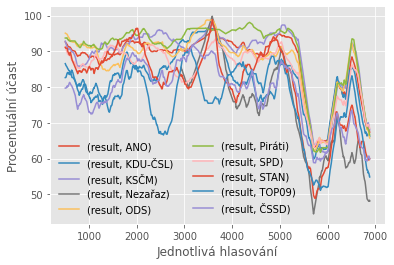

In [24]:
# prepare data
attendance_in_time_data = df.drop(columns=["Vote Title", "Vote description"])
attendance_in_time_data['MP'] = 1
attendance_in_time_data['Vote'] = attendance_in_time_data.Vote.apply(lambda x: 0 if x == "O" or x == "M" else 1)
attendance_in_time_data['Vote Id'] = attendance_in_time_data['Vote Id'] - min_vote_id + 1


# make the computation
attendance_in_time = attendance_in_time_data.groupby(["Vote Id", "Party"]).sum()
attendance_in_time['result'] = attendance_in_time.Vote / attendance_in_time.MP * 100
attendance_in_time = attendance_in_time.drop(columns=["Vote", "MP"]).unstack('Party').reset_index().set_index('Vote Id')

# visualisation
attendance_in_time.rolling(500).mean().plot()
plt.legend(loc='lower left', frameon=False, ncol=2)
plt.ylabel('Procentuální účast')
plt.xlabel('Jednotlivá hlasování')
plt.show()

print()

* this looks cool but the original graph had huge ups and downs so I used `rolling` to get mean value per 500 votings

## Attendance of each MPs
* prepare data by aggregating not-present and active MPs.(value `Omluven` or `Nepřihlášen`)
* then just group by parties and count lines, after that sort the values and plot the data 

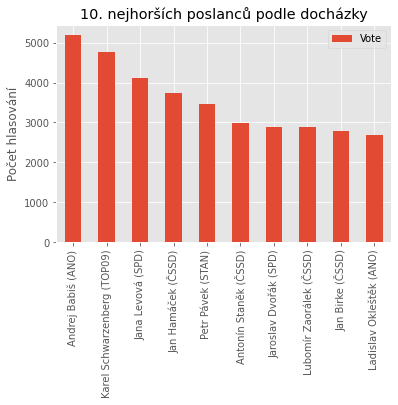

In [10]:
# prepare data
attendance_mps_data = pd.concat([df_0, df_m])[["MP", "Vote", "Party"]]
attendance_mps_data.MP = attendance_mps_data.MP + " (" + attendance_mps_data.Party + ")"
attendance_mps_data = attendance_mps_data.drop(columns=["Party"])

# get the computed data
attendance_mps = attendance_mps_data.groupby("MP").count().sort_values("Vote", ascending=False).head(10)

# make the visualisation
attendance_mps.plot(kind='bar', title="10. nejhorších poslanců podle docházky")
plt.xlabel('')
plt.ylabel('Počet hlasování')

print()

## Corellation between parties based on voting results
* first prepare the data: use only `A` values = MP voted yes.
* drop redundant columns, then group by Vote Id and Party to get  number of Yes votes per party per voting
* then unstack party to transform the matrix to get parties in column and vote ids in rows (plus fill NaN as zeroes)
* create correlation matrix and 
* when comes to `N` - do the same but with different data in the beggining

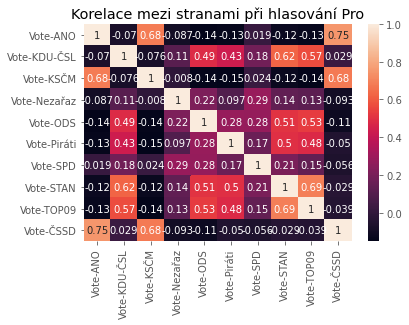

In [19]:
# prepare data
corr_df_data = df_n.drop(columns=['Vote description', 'Vote Title', 'MP'])

#compute the results
corr_matrix = corr_df_data.groupby(["Vote Id", "Party"]).count().unstack('Party').fillna(0).corr()

#visualize the output
sn.heatmap(corr_matrix, annot=True)
plt.xlabel('')
plt.ylabel('')
plt.title("Korelace mezi stranami při hlasování Pro")
plt.show()

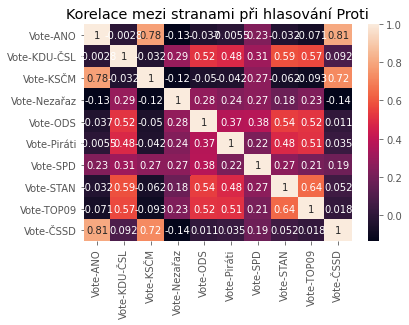

In [35]:
# prepare data
corr_df_data = df_a.drop(columns=['Vote description', 'Vote Title', 'MP'])

#compute the results
corr_matrix = corr_df_data.groupby(["Vote Id", "Party"]).count().unstack('Party').fillna(0).corr()

#visualize the output
sn.heatmap(corr_matrix, annot=True)
plt.xlabel('')
plt.ylabel('')
plt.title("Korelace mezi stranami při hlasování Proti")
plt.show()

## MPs that left a party or joined another party
* prepare the data by selecting Party and MP and then drop duplicates - so if MP will be represented more than once then he or she will be party migrant
* another practical step is to groupby by MP and count and filter out the mps that are represented only once
* then print out the migrants :)

In [21]:
# prepare the input data
party_to_party_migrants_data =  df[["Party", "MP"]].drop_duplicates()

#compute the result
party_to_party_migrants = party_to_party_migrants_data.groupby('MP').filter(lambda x: len(x) > 1).MP.drop_duplicates().reset_index(drop=True)

# print the result
print("List poslanců kteří změnili stranu během volebního období: ", end="")
print(*party_to_party_migrants.tolist(), sep=', ')

List poslanců kteří změnili stranu během volebního období: Václav Klaus, Zuzana Majerová, Marian Bojko, Tereza Hyťhová, Ivana Nevludová, Lubomír Volný, Jaroslav Foldyna


* but that does not say any about parties that lost or get new MPs 
* so I prepared another graph about parties' MPs count in time

In [25]:
# Show time-based number of MPs per Party
time_based_number_mps_data = df[df.Party != "ANO"].drop(columns=["Vote Title", "Vote"])
time_based_number_mps_data['Vote Id'] = time_based_number_mps_data['Vote Id'] - min_vote_id + 1

# computation
time_based_number_mps = time_based_number_mps_data.groupby(["Vote description","Vote Id", "Party"]).count().unstack('Party').reset_index().drop(columns=["Vote description"]).set_index('Vote Id')

# visualize
time_based_number_mps.iloc[::100, :].sort_index().plot()
plt.legend(loc='lower left')
plt.ylabel("Počet poslanců")
plt.xlabel('Jednotlivá hlasování')
plt.title("Počet poslanců jednotlivých stran kromě ANO")

print()

* the data are without ANO party - ANO has 78 MPs all the time - so it is irrelevant for this particular visualisation 
* another interesting information is about MPs that did not finish entire election period

In [36]:
left_or_join_mps = df[["Party", "MP"]].groupby("MP").count().sort_values("Party", ascending=True)
(x,y ) = df.groupby("Vote Id").count().shape

print("Poslanci, kteří nedosloužili celé volební období")
print(left_or_join_mps[left_or_join_mps.Party < x].rename(columns={ "Party": "Počet hlasování"}))

Poslanci, kteří nedosloužili celé volební období
                     Počet hlasování
MP                                  
Jaroslava Pokorná                 16
Jiří Hlavatý                      16
Martin Půta                       16
Irena Blažková                   332
Bohuslav Sobotka                 498
Robert Pelikán                   877
Martin Stropnický               1210
Vladimír Koníček                1546
Dan Ťok                         2464
Milan Chovanec                  2464
Petr Bendl                      3152
Ondřej Babka                    3152
František Navrkal               3392
Mikuláš Peksa                   3487
Radka Maxová                    3727
Veronika Vrecionová             3727
Iva Kalátová                    4415
Václav Votava                   4415
Marie Pěnčíková                 5333
Petr Venhoda                    5669
Monika Červíčková               6002
Roman Sklenák                   6381
Petr Vrána                      6547
Milan Pour                

## Parties' Unity during voting
* to get the most rebelious MPs we need to prepare data by marking  yes and no in numeric way, which allows us to do the sum later.
* we group data by vote and party and then sum the votes
* we create another helper column to hold the information about majority vote of the party
* we divide the data to A and N parts,  for each part we select the votes where party was not united and then merge them back
* to get real results we need to filter data - so we recreate column `Vote` and put there an opposite majority vote
* from the results we sort the worst one and visualize the rest

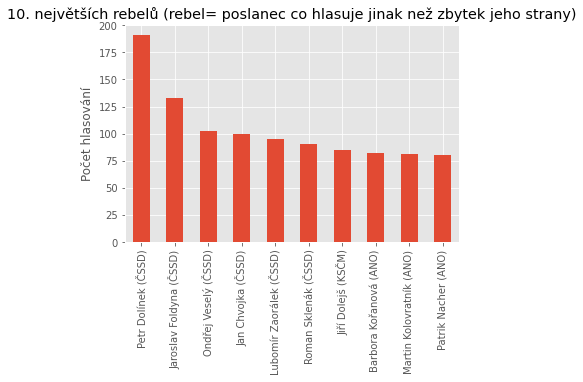

In [27]:

# prepare data
herd_vote_data = pd.concat([df_a, df_n])[["MP", "Vote", "Party", "Vote Id"]]
herd_vote_data.MP = herd_vote_data.MP + " (" + herd_vote_data.Party + ")"
herd_vote_data["Vote_A"] = herd_vote_data.Vote.apply(lambda x: 1 if x == "A" else 0)
herd_vote_data["Vote_N"] = herd_vote_data.Vote.apply(lambda x: 1 if x == "N" else 0)

# get get sum of votes per party per vote
herd_vote = herd_vote_data.groupby(["Vote Id","Party"]).sum().reset_index()

# create helper column - is column Vote_A a majority ? 
herd_vote['result'] = herd_vote["Vote_A"] > herd_vote["Vote_N"]

# divide data into two parts - A is majority and N is majority
herd_vote_n = herd_vote[herd_vote['result'] == False]
herd_vote_a = herd_vote[herd_vote['result'] == True]

# get all votes where parties had at least one vote opposite 
herd_vote_n_res = herd_vote_n[herd_vote_n["Vote_A"] > 0].drop(columns=['Vote_A', 'Vote_N', 'result'])
herd_vote_a_res = herd_vote_a[herd_vote_a["Vote_N"] > 0].drop(columns=['Vote_A', 'Vote_N', 'result'])

# add another helper column to mark the opposite of majority vote
herd_vote_n_res['Vote'] = "A"
herd_vote_a_res['Vote'] = "N"

# merge them together
herd_vote_res = pd.concat([herd_vote_n_res,herd_vote_a_res])

# stackoverflow magic :D 
# it takes data and transform them into tuples and then filter with them original values
# goal is to get mps that voted incorrectly (= against the party majority vote) 
tuples = [tuple(x) for x in herd_vote_res.to_numpy()]
rebel_mps = herd_vote_data[pd.Series(list(zip(df['Vote Id'], df['Party'], df['Vote']))).isin(tuples)]

# get count of rebel actions for every MP and then choose the 10 worst 
top_rebel_mps = rebel_mps.MP.value_counts().head(10)
top_rebel_mps.plot(kind='bar', title="10. největších rebelů (rebel= poslanec co hlasuje jinak než zbytek jeho strany)")
plt.ylabel("Počet hlasování")
print()

* in order to create visualisation of herd mentality of each party(herd mentality = all the MPs of the party vote same or substain) we need to modify data little bit
* we divide the data to get votings where the party voted-as-one and then merge them back
* then group them by party and count the occurences
* finally visualize the data :)

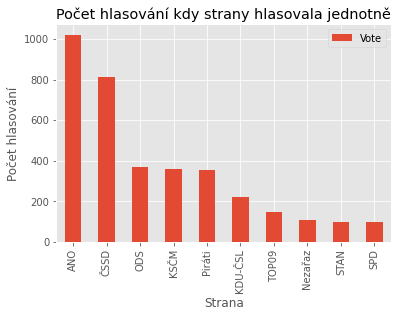

In [34]:
# get data where parties voted as one
herd_vote_n_res_party = herd_vote_n[herd_vote_n["Vote_A"] == 0].drop(columns=['Vote_A', 'Vote_N', 'result'])
herd_vote_a_res_party = herd_vote_a[herd_vote_a["Vote_N"] == 0].drop(columns=['Vote_A', 'Vote_N', 'result'])
herd_vote_res_party = pd.concat([herd_vote_n_res,herd_vote_a_res])

# group the count per party and plot the result
herd_vote_res_party.groupby("Party").count().drop(columns=['Vote Id']).sort_values("Vote", ascending=False).plot(kind='bar', title='Počet hlasování kdy strany hlasovala jednotně')
plt.ylabel("Počet hlasování")
plt.xlabel("Strana")

print()